## Оптимизация маркетинговых затрат

У меня в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.


Цель:
* Помочь маркетологам понять куда и сколько им стоит вкладвать деньги, какие источники/платформы  использовать

Задачи:
* Изучить датасеты, проверить тип данных
* Построить отчеты и посчитать метрики( продукта, продаж, маркетинга)
* Сделать вывод о том, что рекомендовать маркетологам

**Описание данных**

Данные предоставлены в csv-файле.

* визиты: /datasets/visits_log.csv
    * Device - дейвайс с которого посетили сайт
    * Start Ts - начало сессии
    * End Ts - окончание сессии
    * Source Id - идентификатор ресурса
    * Uid - идентификатор пользователя

* заказы: /datasets/orders_log.csv 
    * Buy Ts - время покупки
    * Revenue - выручка за покупку
    * Uid - идентификатор пользователя
    
* расходы: /datasets/costs.csv
    * source_id - идентификатор ресурса
    * dt - дата вложения в рекламу
    * costs -  стоимость рекламных вложений

1. [Открытие данных](#start)
2. [Предобработка данных](#preprocessing)
    * [Обработка дубликатов](#duplicates)
    * [Изменение типов данных](#types)
3. [Построение отчетов и подсчет метрик](#graphicsandmetrics)
    * [DAU, WAU и MAU.](#daumauwau)
    * [Средняя продолжительность сессии, распределение продолжительности сессии](#avrsession)
    * [Retention rate](#retentionrate)
    * [Сколько раз покупают за период](#numberofbuyingsperperiod)
    * [Средний чек](#avrrevenue)
    * [LTV](#ltv)
    * [Общая сумма расходов](#overallcost)
    * [CAC и ROMI](#cacromi)
4. [Построение графиков. Вывод](#conclusion)

<a id='start'></a>
### Шаг 1. Изучение файлов с данными и общей информацией по ним.

In [149]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
path = '/Users/valeriyaniskorodova/Y.Praktikum/Module 2/Sprint 2/'
#path = /datasets/

In [3]:
visits = pd.read_csv(path + 'visits_log.csv')

In [4]:
visits

Device               End Ts  Source Id             Start Ts  \
0         touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1       desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2         touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3       desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4       desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   
...         ...                  ...        ...                  ...   
359395  desktop  2017-07-29 19:07:19          2  2017-07-29 19:07:00   
359396    touch  2018-01-25 17:38:19          1  2018-01-25 17:38:00   
359397  desktop  2018-03-03 10:12:19          4  2018-03-03 10:12:00   
359398  desktop  2017-11-02 10:12:19          5  2017-11-02 10:12:00   
359399    touch  2017-09-10 13:13:19          2  2017-09-10 13:13:00   

                         Uid  
0       16879256277535980062  
1         104060357244891740  
2        7459035603376831527  
3       16174680259334210214  
4        9969694820036681168  
...                      ...  
359395  18363291481961487539  
359396  18370831553019119586  
359397  18387297585500748294  
359398  18388616944624776485  
359399  18396128934054549559  

[359400 rows x 5 columns]

In [5]:
visits.columns = ['device', 'time_session_end', 'source_id', 'time_session_start', 'uid']

In [6]:
path = '/Users/valeriyaniskorodova/Y.Praktikum/Module 2/Sprint 2/'
#path = /datasets/

In [7]:
orders = pd.read_csv('orders_log.csv')

In [8]:
orders

Buy Ts  Revenue                   Uid
0      2017-06-01 00:10:00    17.00  10329302124590727494
1      2017-06-01 00:25:00     0.55  11627257723692907447
2      2017-06-01 00:27:00     0.37  17903680561304213844
3      2017-06-01 00:29:00     0.55  16109239769442553005
4      2017-06-01 07:58:00     0.37  14200605875248379450
...                    ...      ...                   ...
50410  2018-05-31 23:50:00     4.64  12296626599487328624
50411  2018-05-31 23:50:00     5.80  11369640365507475976
50412  2018-05-31 23:54:00     0.30   1786462140797698849
50413  2018-05-31 23:56:00     3.67   3993697860786194247
50414  2018-06-01 00:02:00     3.42     83872787173869366

[50415 rows x 3 columns]

In [9]:
orders.columns = ['order_date', 'revenue', 'uid']

In [10]:
path = '/Users/valeriyaniskorodova/Y.Praktikum/Module 2/Sprint 2/'
#path = '/datasets/'

In [11]:
costs = pd.read_csv(path + 'costs.csv')
costs

source_id          dt  costs
0             1  2017-06-01  75.20
1             1  2017-06-02  62.25
2             1  2017-06-03  36.53
3             1  2017-06-04  55.00
4             1  2017-06-05  57.08
...         ...         ...    ...
2537         10  2018-05-27   9.92
2538         10  2018-05-28  21.26
2539         10  2018-05-29  11.32
2540         10  2018-05-30  33.15
2541         10  2018-05-31  17.60

[2542 rows x 3 columns]

In [12]:
costs.columns = ['source_id', 'date', 'costs']


<a id='preprocessing'></a>
### Шаг 2.Предобработка данных

In [13]:
# лог сервера с информацией о посещениях сайта
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   device              359400 non-null  object
 1   time_session_end    359400 non-null  object
 2   source_id           359400 non-null  int64 
 3   time_session_start  359400 non-null  object
 4   uid                 359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


<a id='types'></a>
Приведу такие столбцы, как **time_session_end** и **time_session_start** к типу datetime, а **uid** и **source_id** к типу object, чтобы не произошло случайних математических операций между столбцами.

In [14]:
for column_name in ('time_session_end', 'time_session_start'):
    visits[column_name] = pd.to_datetime(visits[column_name])
id_dict = {
    'source_id':'str',
    'uid':'str'
}
visits = visits.astype(id_dict)

In [15]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   device              359400 non-null  object        
 1   time_session_end    359400 non-null  datetime64[ns]
 2   source_id           359400 non-null  object        
 3   time_session_start  359400 non-null  datetime64[ns]
 4   uid                 359400 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 13.7+ MB


In [16]:
visits.duplicated().sum()

0

<a id='duplicates'></a>
В таблице visits дубликатов не обнаружено

In [17]:
# таблица с информацией о заказах
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_date  50415 non-null  object 
 1   revenue     50415 non-null  float64
 2   uid         50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [18]:
orders['order_date'] = pd.to_datetime(orders['order_date'])
orders['uid'] = orders['uid'].astype('str')

In [19]:
orders.duplicated().sum()

0

In [20]:
# информация о затратах на маркетинг
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   date       2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [21]:
costs['source_id'] = costs['source_id'].astype('str')
costs['date'] = pd.to_datetime(costs['date'])

In [22]:
costs.duplicated().sum()

0

Типы данных во всех табличак приведены к нужному типу.

<a id='graphicsandmetrics'></a>
### Шаг 3. Построение отчетов и подсчет метрик.

#### 1. Таблица visits

In [23]:
visits

device    time_session_end source_id  time_session_start  \
0         touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1       desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2         touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3       desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4       desktop 2017-12-27 14:06:00         3 2017-12-27 14:06:00   
...         ...                 ...       ...                 ...   
359395  desktop 2017-07-29 19:07:19         2 2017-07-29 19:07:00   
359396    touch 2018-01-25 17:38:19         1 2018-01-25 17:38:00   
359397  desktop 2018-03-03 10:12:19         4 2018-03-03 10:12:00   
359398  desktop 2017-11-02 10:12:19         5 2017-11-02 10:12:00   
359399    touch 2017-09-10 13:13:19         2 2017-09-10 13:13:00   

                         uid  
0       16879256277535980062  
1         104060357244891740  
2        7459035603376831527  
3       16174680259334210214  
4        9969694820036681168  
...                      ...  
359395  18363291481961487539  
359396  18370831553019119586  
359397  18387297585500748294  
359398  18388616944624776485  
359399  18396128934054549559  

[359400 rows x 5 columns]

In [150]:
warnings.filterwarnings('ignore')

In [151]:
visits['date'] = visits['time_session_start'].dt.date
visits['week'] = visits['time_session_start'].dt.week
visits['month'] = visits['time_session_start'].dt.month
visits['year'] = visits['time_session_start'].dt.year

Найду устройство и ресурс, с которого пользователь заходил первый раз.

In [25]:
visits_first = visits.groupby('uid')['source_id'].first()
visits_first.name = 'first_source_id'

In [26]:
visits_device = visits.groupby('uid')['device'].first()
visits_device.name = 'first_device'

In [27]:
visits = visits.merge(visits_first, on='uid')
visits = visits.merge(visits_device, on='uid')

Разделю таблицы по устройствам, которые люди использовали, когда посещали сайт.

In [28]:
desktop_visits = visits[visits['device'] == 'desktop']
touch_visits = visits[visits['device']== 'touch']

<a id='daumauwau'></a>
Посчитаем такие метрики как DAU, WAU и MAU, чтобы оценить сколько людей пользуется в день, неделю, месяц

In [29]:
dau_total = visits.groupby(['date', 'week']).agg({'uid':'nunique'})
dau_total_desktop = desktop_visits.groupby(['date', 'week']).agg({'uid':'nunique'})
dau_total_visits = touch_visits.groupby(['date', 'week']).agg({'uid':'nunique'})

In [30]:
print('В среднем, в день на сайт Яндекс.Афиши заходит {} человек.'.
      format(int(dau_total.mean())))

В среднем, в день на сайт Яндекс.Афиши заходит 907 человек.


In [31]:
print('В среднем, в день на сайт Яндекс.Афиши с компьютера заходит {} человек.'.
      format(int(dau_total_desktop.mean())))

В среднем, в день на сайт Яндекс.Афиши с компьютера заходит 659 человек.


In [32]:
print('В среднем, в день на сайт Яндекс.Афиши с телефоном/планшетов заходит {} человек.'.
      format(int(dau_total_visits.mean())))

В среднем, в день на сайт Яндекс.Афиши с телефоном/планшетов заходит 252 человек.


Очень заметна разница между посещениями с компьютера и планшета. С компьютера люди заходят почти в 2,6 раза чаще, чем с остальных устройств.

In [33]:
dau_total = dau_total.reset_index()

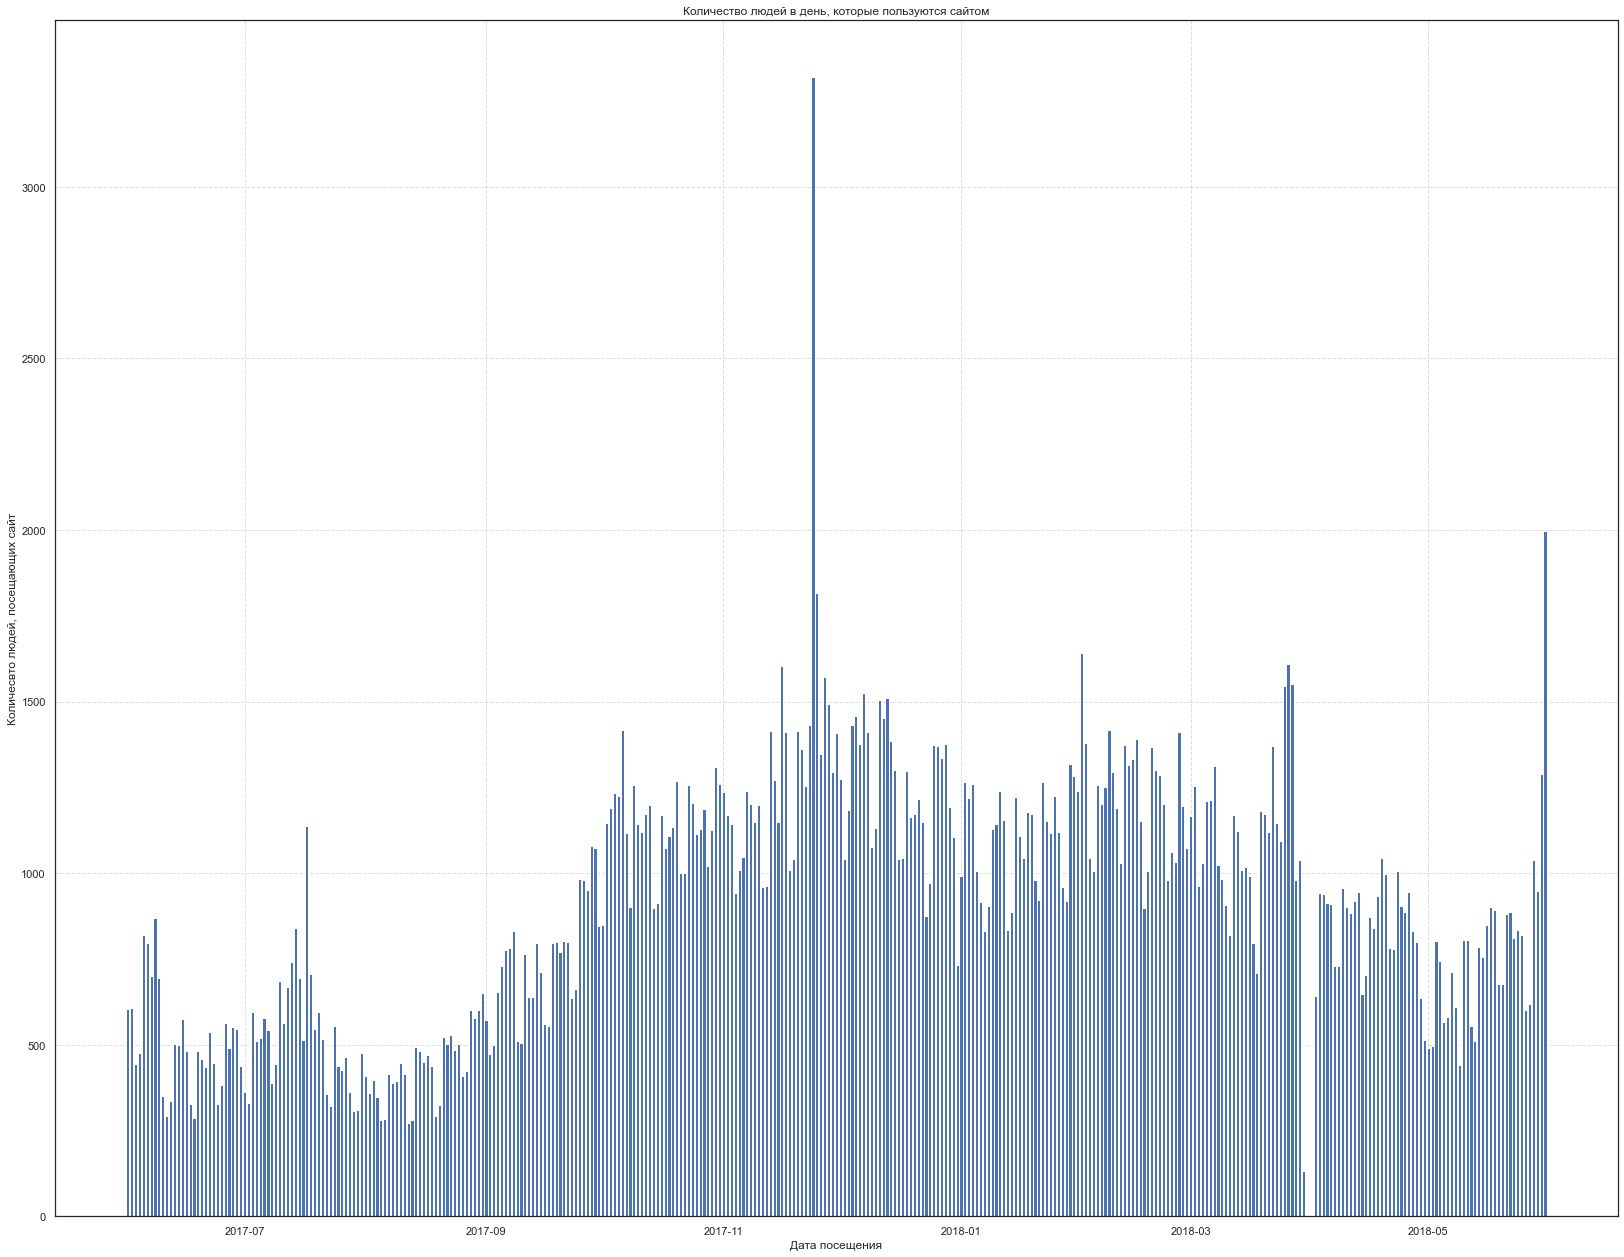

In [162]:
plt.figure(figsize=(28,22))
plt.bar(dau_total['date'], dau_total['uid'])
plt.grid(True, linestyle='--', color='grey', which = 'major', alpha=.25)
plt.ylabel('Количесвто людей, посещающих сайт')
plt.xlabel('Дата посещения')
plt.title('Количество людей в день, которые пользуются сайтом')
plt.show()

Из графика видно, что в конце 2017 года и в начале 2018 года очень большое количество людей пришло на сайт ( около 1250 человек), также можно заметить, что с октября 2017 года по апрель 2018 года были стабильно высокие показатели посещение сайта относительно других дней, что может говорить о правильном вкладе маркетинга, раз была привлечено такое количество посетителей. Проверю это предположение чуть позже. Есть довольно аномальное значение, предлагаю его запомнить, чтобы потом проверить, является ли это случайностью или люди пришли из-за определенных вкладов команды маркетинга в рекламы и т.д.

In [35]:
dau_total['uid'].max()

3319

In [36]:
dau_total[dau_total['uid'] == 3319]

date  week   uid
176  2017-11-24    47  3319

In [37]:
wau_total = visits.groupby(['year','week']).agg({'uid':'nunique'})
wau_desktop = desktop_visits.groupby(['year','week']).agg({'uid':'nunique'})
wau_touch = touch_visits.groupby(['year','week']).agg({'uid':'nunique'})

In [38]:
print('За неделю, в среднем, сайт посещают {} человек.'.format(int(wau_total.mean())))

За неделю, в среднем, сайт посещают 5716 человек.


In [39]:
print('За неделю, в среднем, сайт посещают c компьютера {} человек.'.format(int(wau_desktop.mean())))

За неделю, в среднем, сайт посещают c компьютера 4129 человек.


In [40]:
print('За неделю, в среднем, сайт посещают c телефона/планшета {} человек.'.format(int(wau_touch.mean())))

За неделю, в среднем, сайт посещают c телефона/планшета 1634 человек.


В среднем, с компьютера, посетители заходят на сайт чаще, чем с остальных устройтв.

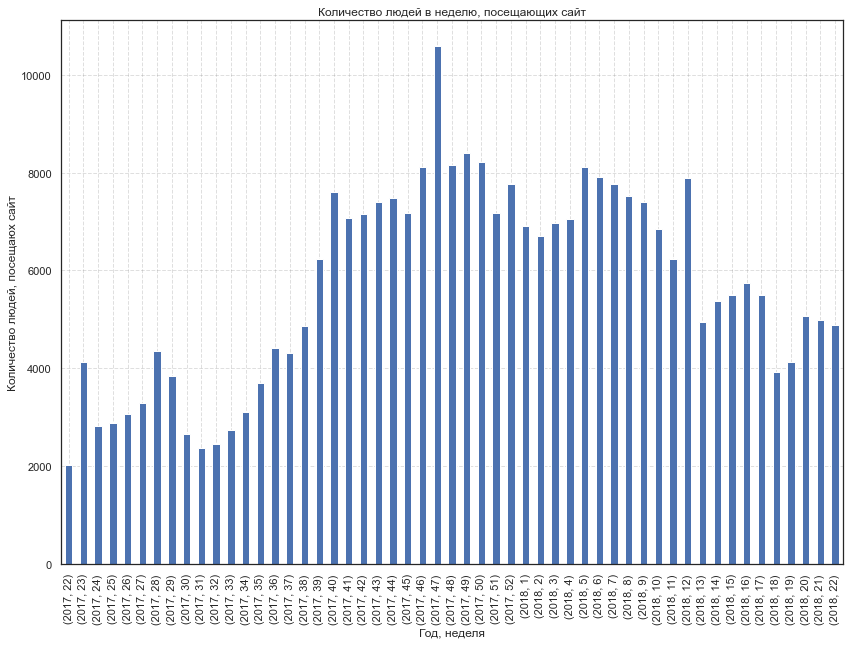

In [155]:
wau_total.plot(kind='bar',figsize=(14,10), legend=False)
plt.grid(True, linestyle='--', color='grey', which='major', alpha=.25)
plt.title('Количество людей в неделю, посещающих сайт')
plt.xlabel('Год, неделя')
plt.ylabel('Количество людей, посещаюх сайт')
plt.show()

В 2017 году количество посетителей растет к концу года, в 2018 года в начале их больше, нежели чем к середине года. В 2017 году есть неделя, с довольно большим количесвтвом посетителей, именно на этой неделе в прошлом исследовании мы нашли аномальные данные.

In [42]:
mau_total = visits.groupby(['year', 'month']).agg({'uid':'nunique'})
mau_desktop = desktop_visits.groupby(['year', 'month']).agg({'uid':'nunique'})
mau_touch = touch_visits.groupby(['year', 'month']).agg({'uid':'nunique'})

In [43]:
print('В среднем, в месяц  - {} посещений.'.format(int(mau_total.mean())))

В среднем, в месяц  - 23228 посещений.


In [44]:
print('В среднем, в месяц  - {} посещений с компьютера.'.format(int(mau_desktop.mean())))

В среднем, в месяц  - 16724 посещений с компьютера.


In [45]:
print('В среднем, в месяц  - {} посещений с телефона/планшета.'.format(int(mau_touch.mean())))

В среднем, в месяц  - 6825 посещений с телефона/планшета.


Из рассчитанных метрик в срезе девайсов видно, что посещений с компьютера впринципе больше. Это может быть связанно с тем, что совершать покупки намного удобнее с компьютера, да и в целом, просматривать сайт тоже. Может быть мобильная версия приложения не  совсем удобна для пользователя, что привело к том, что большинство используют компьютер.

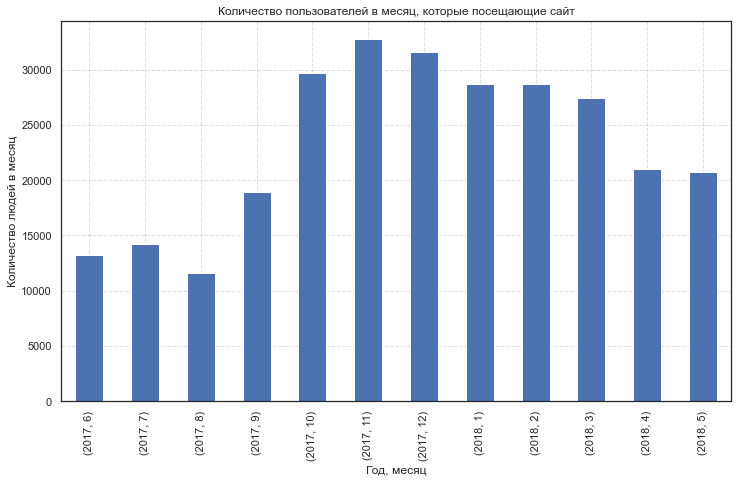

In [163]:
mau_total.plot(kind='bar', figsize=(12,7), legend=False)
plt.grid(True, linestyle='--', color='grey', which='major', alpha=.25)
plt.xlabel('Год, месяц')
plt.ylabel('Количество людей в месяц')
plt.title('Количество пользователей в месяц, которые посещающие сайт')
plt.show()

Видим, что с 2017 года количество посещений сайта в месяц растет, но падает до 20000 людей в месяц к середине 2018 года.

---
Довольно неплохие показатели. Рассчитаю липкий фактор.

In [47]:
sticky_factor_dw = dau_total.mean() / wau_total.mean() * 100
sticky_factor_dw_desktop = dau_total_desktop.mean() / wau_desktop.mean() * 100
sticky_factor_dw_touch = dau_total_visits.mean() / wau_touch.mean() * 100

In [48]:
sticky_factor_dw

uid     15.884409
week          NaN
dtype: float64

In [49]:
sticky_factor_dw_desktop

uid    15.964233
dtype: float64

In [50]:
sticky_factor_dw_touch

uid    15.46697
dtype: float64

In [51]:
sticky_factor_dm = dau_total.mean() / mau_total.mean() * 100
sticky_factor_dm_desktop = dau_total_desktop.mean() / mau_desktop.mean()
sticky_factor_dm_touch = dau_total_visits.mean() / mau_touch.mean()

In [52]:
sticky_factor_dm_desktop

uid    0.039417
dtype: float64

In [53]:
sticky_factor_dm_desktop

uid    0.039417
dtype: float64

In [54]:
sticky_factor_dm_touch

uid    0.037046
dtype: float64

Эта метрика показывает, как часто пользователи обращаются на сайт. Вовлеченность пользователей в неделю выше в 5 раз, нежели, чем в месяц. Получается, что часть людей отваливаются в течении месяца. С одной стороны это может быть из-за того, что пользователи не покупают билеты на концерты и музеи ежедневно. С другой стороны, может быть так, что они отваливаются по определенным причинам неудобства пользования сайтом.

Заметно, что "липкий фактор" не меняется при срезе по устройству, с которого люди заходили на сайт. То есть отношение людей, посещаюх сайт в день к неделе и месяцу остается неизменным.

---

<a id='avrsession'></a>
Посмотрим сколько сессий в месяц проводит пользователь.

In [55]:
visits

device    time_session_end source_id  time_session_start  \
0         touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1       desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2         touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3       desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4       desktop 2018-03-09 20:33:00         4 2018-03-09 20:05:00   
...         ...                 ...       ...                 ...   
359395  desktop 2018-04-23 21:19:00        10 2018-04-23 21:11:00   
359396  desktop 2017-11-08 13:39:00         4 2017-11-08 13:39:00   
359397  desktop 2017-07-31 12:31:00         3 2017-07-31 12:13:00   
359398  desktop 2018-03-20 15:25:00         4 2018-03-20 15:11:00   
359399    touch 2018-04-03 11:23:00         5 2018-04-03 11:19:00   

                         uid        date  week  month  year first_source_id  \
0       16879256277535980062  2017-12-20    51     12  2017               4   
1         104060357244891740  2018-02-19     8      2  2018               2   
2        7459035603376831527  2017-07-01    26      7  2017               5   
3       16174680259334210214  2018-05-20    20      5  2018               9   
4       16174680259334210214  2018-03-09    10      3  2018               9   
...                      ...         ...   ...    ...   ...             ...   
359395  12734910664455613822  2018-04-23    17      4  2018              10   
359396   6761309174945977743  2017-11-08    45     11  2017               4   
359397  11102751930812818282  2017-07-31    31      7  2017               3   
359398    272012551460639309  2018-03-20    12      3  2018               4   
359399   3266363999948772866  2018-04-03    14      4  2018               5   

       first_device  
0             touch  
1           desktop  
2             touch  
3           desktop  
4           desktop  
...             ...  
359395      desktop  
359396      desktop  
359397      desktop  
359398      desktop  
359399        touch  

[359400 rows x 11 columns]

In [56]:
# функция для подсчета сессий в день
def session_amount(df):
    session_amount = df.groupby(['year', 'date']).agg({'uid':'nunique'})
    session_amount.columns = ['n_session']
    
    return session_amount['n_session'].mean()

In [57]:
('{} сессий в среднем в день у сайта Яндекс Афиша'.format(int(session_amount(visits))))

'907 сессий в среднем в день у сайта Яндекс Афиша'

In [58]:
('{} сессий в среднем в день у сайта Яндекс Афиша совершено с компьютера'.\
 format(int(session_amount(desktop_visits))))

'659 сессий в среднем в день у сайта Яндекс Афиша совершено с компьютера'

In [59]:
('{} сессий в среднем в день у сайта Яндекс Афиша совершено с телефона'.\
 format(int(session_amount(touch_visits))))

'252 сессий в среднем в день у сайта Яндекс Афиша совершено с телефона'


С компьютера пользователи сервиса Яндекс Афиша заходят в 2.6 раз чаще в среднем в день, чем с телефона.

---

Посчитаю теперь среднюю продолжительность сессии.

Посмотрим на распределение, чтобы понять какое среднее мне нужно посчитать.

<AxesSubplot:>

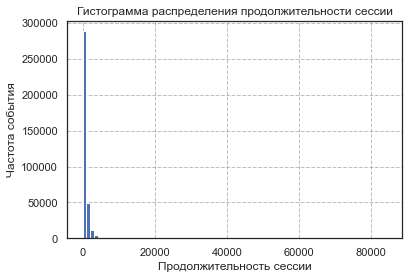

0    60
dtype: int64

In [175]:
visits['session_duration_sec'] = (visits['time_session_end'] - 
                                  visits['time_session_start']).dt.seconds
display(visits['session_duration_sec'].hist(bins=80))
plt.title('Гистограмма распределения продолжительности сессии')
plt.xlabel('Продолжительность сессии')
plt.ylabel('Частота события')
plt.grid(True, linestyle='--', color='grey', which='major', alpha=.5)
plt.show()
display(visits['session_duration_sec'].mode())

<AxesSubplot:>

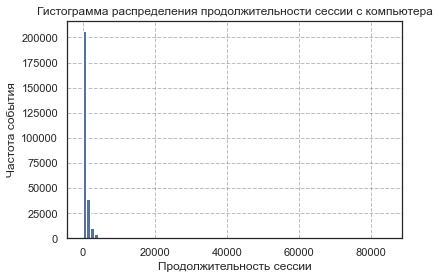

0    60
dtype: int64

In [176]:
desktop_session_duration = visits[visits['first_device'] == 'desktop']
display(desktop_session_duration['session_duration_sec'].hist(bins=80))
plt.title('Гистограмма распределения продолжительности сессии с компьютера')
plt.xlabel('Продолжительность сессии')
plt.ylabel('Частота события')
plt.grid(True, linestyle='--', color='grey', which='major', alpha=.5)
plt.show()
display(desktop_session_duration['session_duration_sec'].mode())

<AxesSubplot:>

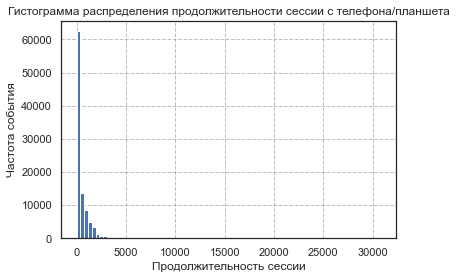

0    60
dtype: int64

In [178]:
touch_session_duration = visits[visits['first_device'] == 'touch']
display(touch_session_duration['session_duration_sec'].hist(bins=80))
plt.title('Гистограмма распределения продолжительности сессии c телефона/планшета')
plt.xlabel('Продолжительность сессии')
plt.ylabel('Частота события')
plt.grid(True, linestyle='--', color='grey', which='major', alpha=.5)
plt.show()
display(touch_session_duration['session_duration_sec'].mode())

Так как наше распределение не похоже на нормальное распределение, то я рассчитывала моду.

И на телефоне/планшете и на компьютере пользователи в среднем проводят 60 секунд.

Видно, что продолжительность сессии в среднем занимает 60 секунд. Довольно небольшое значение, чтобы выбрать билет в театр, кино, концерт и успеть его оплатить( только в случае, если человек уже знает, что конкретно он собирается приобретать, что бывает редко). Получается, отсюда можно предположить, что большинство даже не доходят до момента оплаты билетов.

Если не говорить, про покупку билетов, то для выбора куда сходить требуется намного больше времени.

---

<a id='retentionrate'></a>
Рассчитаю Retention rate, чтобы понять как часто возвращаются люди. Для начала найду даты первого посещения для каждого пользователя, так как в нашей таблице записаны даты начала каждой сессии, то таким образом я смогу понять, когда пользователь вернулся на сайт.

In [63]:
# опредление даты первого посещения сайта
def first_activity(df):
    first_activity_date = df.groupby('uid')['time_session_start'].min()
    first_activity_date.name = 'first_activity_date'
    users_activity = df.join(first_activity_date, on='uid')
    return users_activity

In [64]:
first_activity(visits)

device    time_session_end source_id  time_session_start  \
0         touch 2017-12-20 17:38:00         4 2017-12-20 17:20:00   
1       desktop 2018-02-19 17:21:00         2 2018-02-19 16:53:00   
2         touch 2017-07-01 01:54:00         5 2017-07-01 01:54:00   
3       desktop 2018-05-20 11:23:00         9 2018-05-20 10:59:00   
4       desktop 2018-03-09 20:33:00         4 2018-03-09 20:05:00   
...         ...                 ...       ...                 ...   
359395  desktop 2018-04-23 21:19:00        10 2018-04-23 21:11:00   
359396  desktop 2017-11-08 13:39:00         4 2017-11-08 13:39:00   
359397  desktop 2017-07-31 12:31:00         3 2017-07-31 12:13:00   
359398  desktop 2018-03-20 15:25:00         4 2018-03-20 15:11:00   
359399    touch 2018-04-03 11:23:00         5 2018-04-03 11:19:00   

                         uid        date  week  month  year first_source_id  \
0       16879256277535980062  2017-12-20    51     12  2017               4   
1         104060357244891740  2018-02-19     8      2  2018               2   
2        7459035603376831527  2017-07-01    26      7  2017               5   
3       16174680259334210214  2018-05-20    20      5  2018               9   
4       16174680259334210214  2018-03-09    10      3  2018               9   
...                      ...         ...   ...    ...   ...             ...   
359395  12734910664455613822  2018-04-23    17      4  2018              10   
359396   6761309174945977743  2017-11-08    45     11  2017               4   
359397  11102751930812818282  2017-07-31    31      7  2017               3   
359398    272012551460639309  2018-03-20    12      3  2018               4   
359399   3266363999948772866  2018-04-03    14      4  2018               5   

       first_device  session_duration_sec first_activity_date  
0             touch                  1080 2017-12-20 17:20:00  
1           desktop                  1680 2018-02-19 16:53:00  
2             touch                     0 2017-07-01 01:54:00  
3           desktop                  1440 2018-03-09 20:05:00  
4           desktop                  1680 2018-03-09 20:05:00  
...             ...                   ...                 ...  
359395      desktop                   480 2018-04-23 21:11:00  
359396      desktop                     0 2017-11-08 13:39:00  
359397      desktop                  1080 2017-07-31 12:13:00  
359398      desktop                   840 2018-03-20 15:11:00  
359399        touch                   240 2018-04-03 11:19:00  

[359400 rows x 13 columns]

In [191]:
def retention_rate(users_activity):
    users_activity['first_activity_month'] = users_activity['first_activity_date'].\
    astype('datetime64[M]')
    users_activity['month_session_start'] = users_activity['time_session_start'].\
    astype('datetime64[M]')
    
    # время жизни для каждой строчки датафрейма
    users_activity['lifetime'] = users_activity['month_session_start'] -\
    users_activity['first_activity_month']
    users_activity['lifetime'] = users_activity['lifetime'] / np.timedelta64(1,'M')
    users_activity['lifetime'] = round(users_activity['lifetime'])
    users_activity['lifetime'] = users_activity['lifetime'].astype(int)
    
    for column_name in ['first_activity_date', 'month_session_start', 'first_activity_month']:
        users_activity[column_name] = users_activity[column_name].dt.date
    # количество активных пользователей в месяц
    cohorts = users_activity.groupby(['first_activity_month', 'lifetime']).\
    agg({'uid':'nunique'}).reset_index()
    
    #количество пользователей, которое было изначально в когорте, 
    # разделю каждое последующее число
    # на количество людей в каждую неделю, чтобы получить значение Retention Rate
    initial_users_cohorts = cohorts[cohorts['lifetime'] == 0][['first_activity_month', 'uid']]
    initial_users_cohorts = initial_users_cohorts.rename(columns=({'uid':'cohort_users'}))
    cohorts = cohorts.merge(initial_users_cohorts, on='first_activity_month')
    cohorts['retention_rate'] = cohorts['uid'] / cohorts['cohort_users']
    retention_pivot = cohorts.pivot_table(index='first_activity_month',
                   columns='lifetime',
                   values='retention_rate',
                   aggfunc='sum')
    return retention_pivot

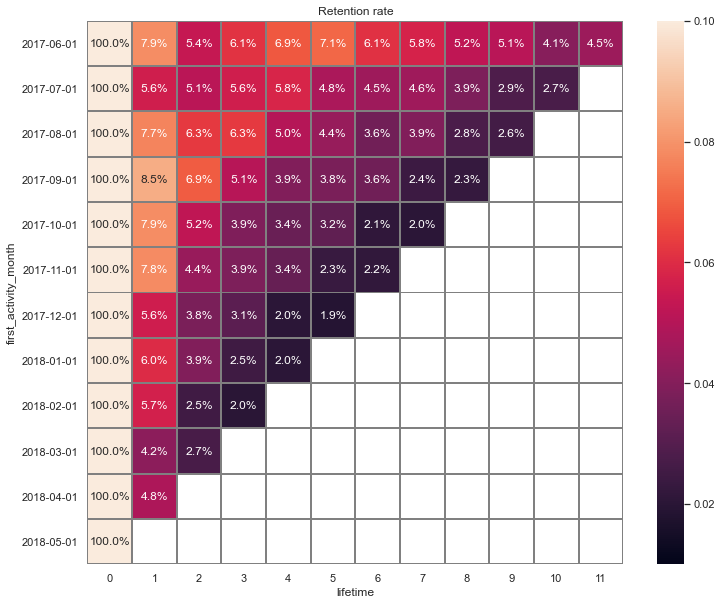

In [204]:
sns.set(style='white')
plt.figure(figsize=(12,10))
plt.title('Retention rate')
sns.heatmap(retention_rate(first_activity(visits)), annot=True, fmt='.1%',\
            linewidth=1, linecolor='grey', vmin= 0.01, vmax=0.1)
plt.show()


У первой когорты достаточно высокий Retention Rate, со временем он упал, конечно, но из всех когорот он сохранял не плохие показатели в течении времени. У второй когорты Retention rate сохраняет стабильные показатели в течении времени. К 6 месяцу жизни у когорт до 2017-07-10 поднимается этот показатель, потом падает.


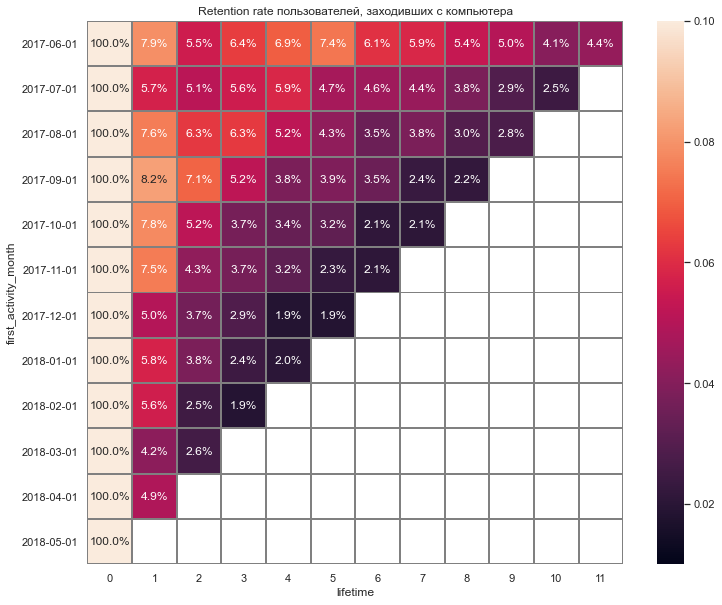

In [205]:
sns.set(style='white')
plt.figure(figsize=(12,10))
plt.title('Retention rate пользователей, заходивших с компьютера')
sns.heatmap(retention_rate(first_activity(desktop_visits)), annot=True, fmt='.1%',\
            linewidth=1, linecolor='grey',  vmin= 0.01, vmax=0.1)
plt.show()


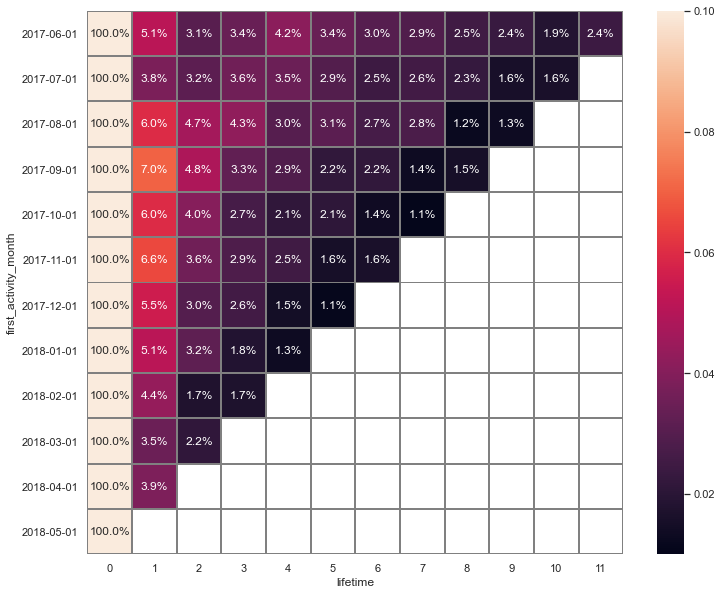

In [206]:
sns.set(style='white')
plt.figure(figsize=(12,10))
sns.heatmap(retention_rate(first_activity(touch_visits)), annot=True, fmt='.1%',\
            linewidth=1, linecolor='grey',  vmin= 0.01, vmax=0.1)
plt.show()


Так же, заметно, что в целом Retention rate у людей, пользующихся компьютером выше, чем у тех, кто посещает сайт с телефона или планшета. Это может говорить о том, что версия мобильная недостаточно доработанная, имеет свои неудобства, что вынуждает посетителей вернуться, но уже с компьютера.

Ресурс номер 4


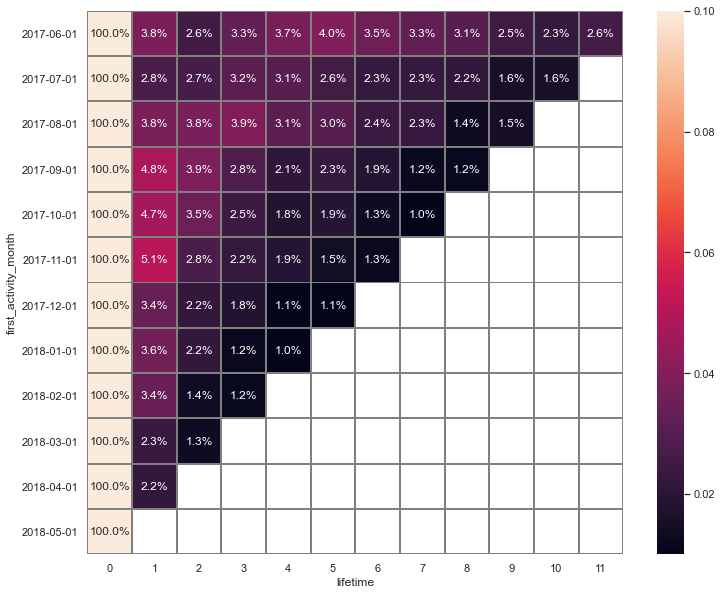

Ресурс номер 2


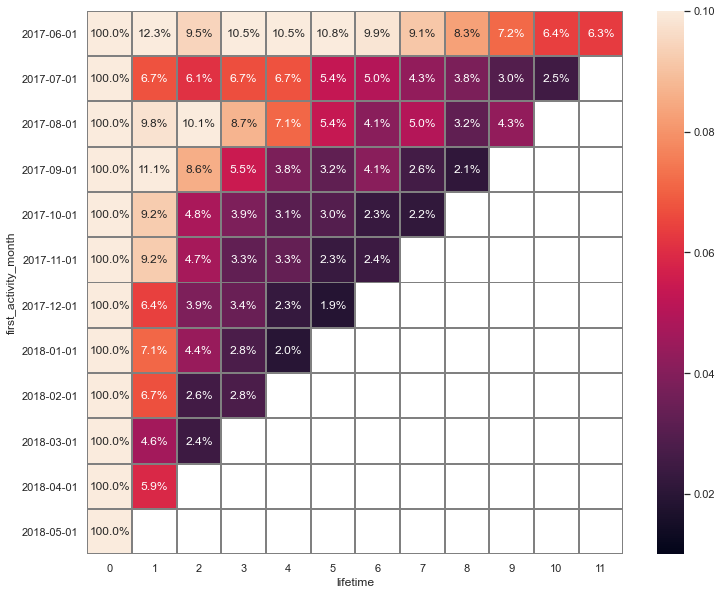

Ресурс номер 5


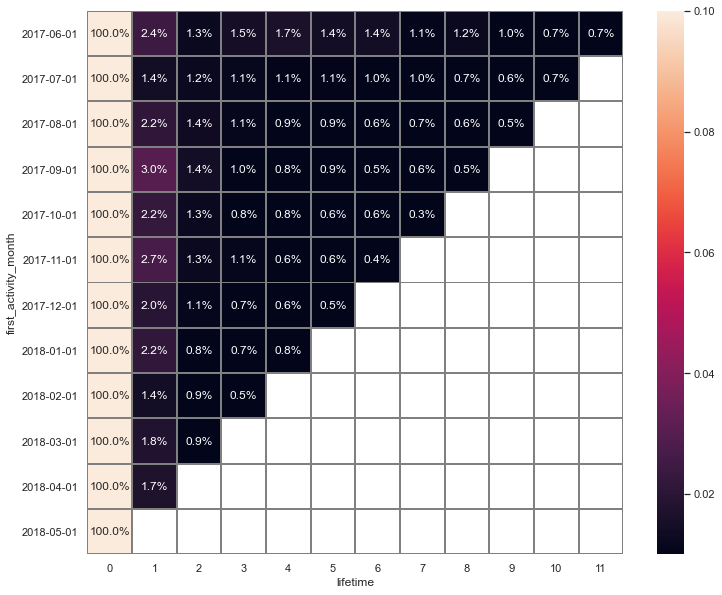

Ресурс номер 9


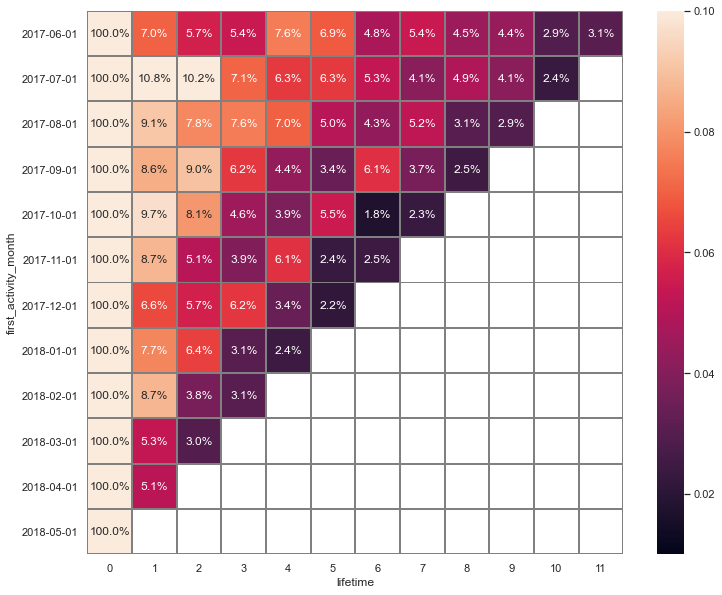

Ресурс номер 3


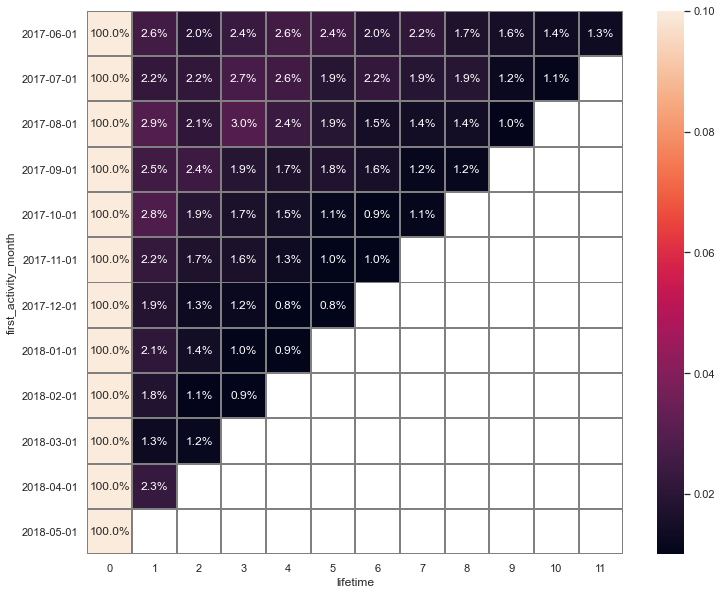

Ресурс номер 1


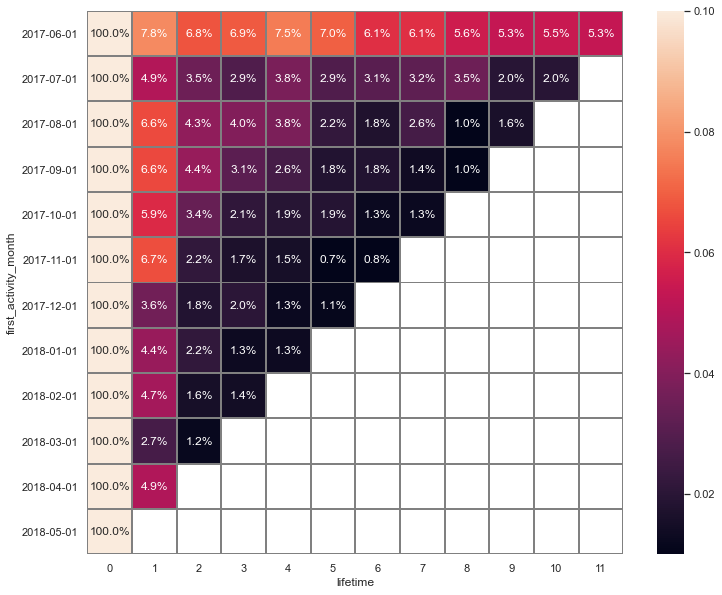

Ресурс номер 10


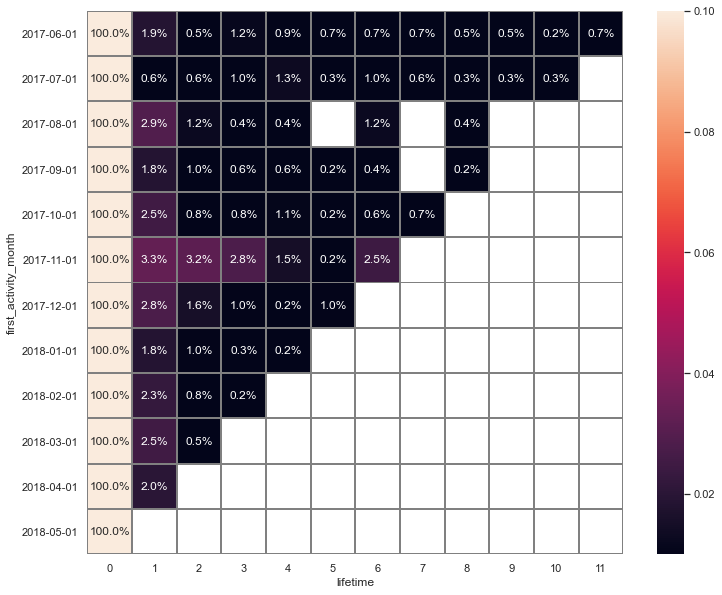

Ресурс номер 7


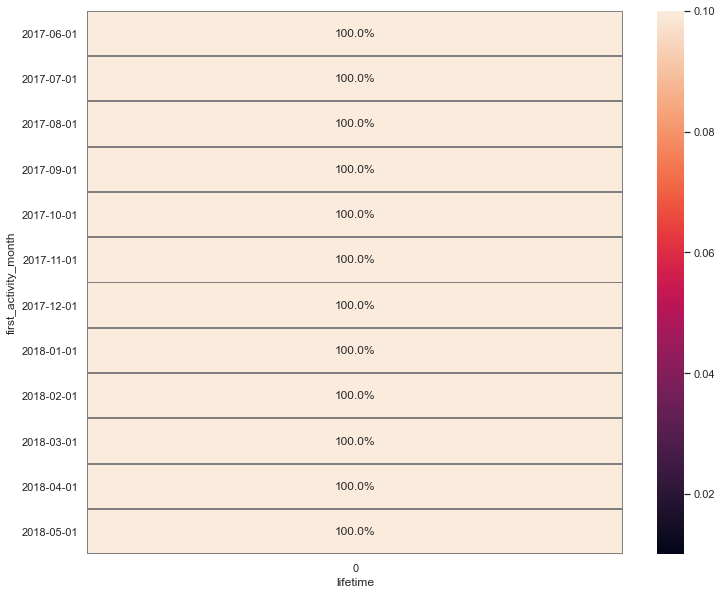

Ресурс номер 6


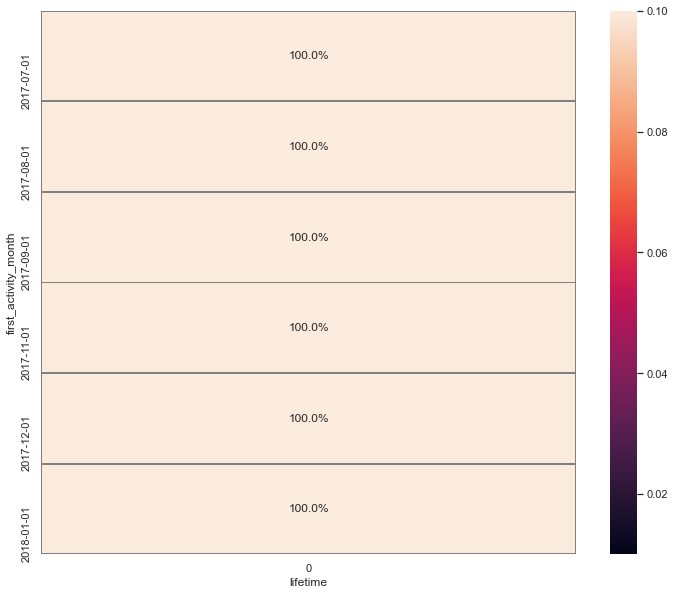

In [207]:
for source in visits['source_id'].unique():
    print('Ресурс номер {}'.format(source))
    first_source_visits = visits[visits['source_id'] == source]
        
    sns.set(style='white')
    plt.figure(figsize=(12,10))
    sns.heatmap(retention_rate(first_activity(first_source_visits)), annot=True, fmt='.1%',\
            linewidth=1, linecolor='grey',  vmin= 0.01, vmax=0.1)
    plt.show()

Если рассматривать таблицу в разрезе ресурсов, то наилучшие показатели за все время наблюдались у 2 ресурса, то есть через него люди возвращаются чаще всего. У ресурса 9 есть некоторые когорты, в первые 3 месяца у которых сохраняется высокий показатель Retntion Rate. У первого ресурса первой когорты одни из высоких показаетелей.


Пользователи, пришедшие из ресурсов 6 и 7 больше не возвращались на сайт. Значит, что эти ресурсы довольно неэффективны.


#### 2. Таблица orders

In [70]:
# таблица с информацией о заказах
orders.head()

order_date  revenue                   uid
0 2017-06-01 00:10:00    17.00  10329302124590727494
1 2017-06-01 00:25:00     0.55  11627257723692907447
2 2017-06-01 00:27:00     0.37  17903680561304213844
3 2017-06-01 00:29:00     0.55  16109239769442553005
4 2017-06-01 07:58:00     0.37  14200605875248379450

In [71]:
def first_activity_date(visits):
    # дата первого захода на сайт
    first_activity_date = visits.groupby('uid')['time_session_start'].min()
    first_activity_date.name = 'first_activity_date'
    first_activity_date = first_activity_date.reset_index()
    return first_activity_date

In [72]:
first_activity_date(visits)

uid first_activity_date
0       10000171586432207426 2017-12-01 15:11:00
1       10000344846682484395 2018-02-21 16:01:00
2        1000036778515242839 2017-09-05 20:22:00
3       10000460875579931334 2017-09-13 09:12:00
4       10000558740593440652 2018-01-03 18:39:00
...                      ...                 ...
228164   9999530179466660745 2017-06-14 14:33:00
228165   9999704916412649026 2017-06-29 23:04:00
228166   9999829453910784044 2017-11-09 15:32:00
228167   9999912853550499774 2017-08-18 09:23:00
228168   9999996800317156310 2017-11-24 17:22:00

[228169 rows x 2 columns]

In [73]:
# дата первой покупки
first_order_date = orders.groupby('uid')['order_date'].min()
first_order_date.name = 'first_order_date'
first_order_date = first_order_date.reset_index()
first_order_date.head()

uid    first_order_date
0  10000837700716403746 2017-06-21 16:12:00
1  10000997030965831953 2018-01-19 12:28:00
2  10001199569370567060 2017-11-25 17:29:00
3  10002243978166172255 2017-10-15 17:20:00
4  10003351403065971701 2017-11-20 13:18:00

In [212]:
def order_duration(visits):
    order_duration = visits.merge(first_order_date, on='uid')
    order_duration['first_oders_sec'] = (order_duration['first_order_date'] - \
                                 order_duration['first_activity_date']).dt.seconds
    display(order_duration['first_oders_sec'].hist(bins=80))
    plt.grid(True, linestyle='--')
    display(order_duration['first_oders_sec'].mode())

<AxesSubplot:>

0    60
dtype: int64

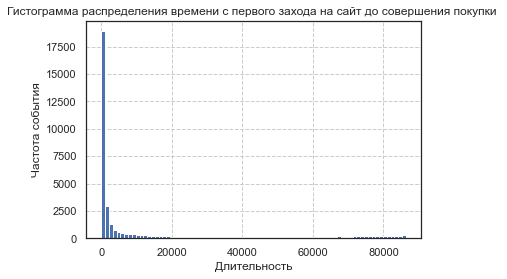

In [215]:
order_duration(first_activity_date(visits))
plt.title('Гистограмма распределения времени с первого захода на сайт до совершения покупки ')
plt.xlabel('Длительность')
plt.ylabel('Частота события')
plt.show()

Сделаю срез таблицы по девайсу, который использовал пользователь, когда заходил первый раз.


In [76]:
desktop = visits[visits['first_device'] == 'desktop']

In [77]:
touch = visits[visits['first_device'] == 'touch']

<AxesSubplot:>

0    60
dtype: int64

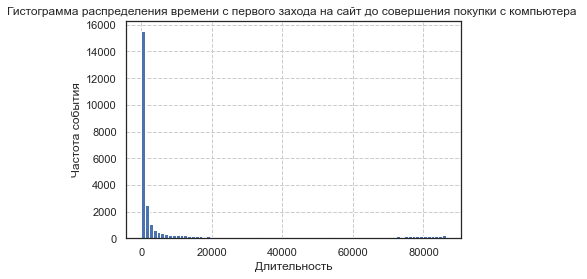

In [216]:
order_duration(first_activity_date(desktop))
plt.title('Гистограмма распределения времени с первого захода на сайт до совершения покупки c компьютера ')
plt.xlabel('Длительность')
plt.ylabel('Частота события')
plt.show()

<AxesSubplot:>

0    0
dtype: int64

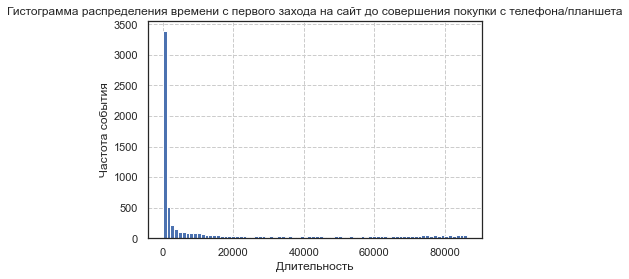

In [218]:
order_duration(first_activity_date(touch))
plt.title('Гистограмма распределения времени с первого захода на сайт до совершения покупки с телефона/планшета')
plt.xlabel('Длительность')
plt.ylabel('Частота события')
plt.show()

Через 60 секунд пользователь чаще всего производит покупку. Если разбить датафрейм по девайсам, то можно увидеть, что чаще всего люди начинают покупать сразу же. Вполне вероятно они переходят по прямой ссылке сразу на страницу покупки.

---

<a id='numberofbuyingsperperiod'></a>
Теперь нужно понять **сколько раз покупают за период**.

In [80]:
# функция для соединения таблицы
def merge_table(df):
    first = df.merge(first_order_date, on='uid')
    orders_n = orders.merge(first, on='uid')
    
    return orders_n

In [81]:
# функция для записи первого месяца покупки и месяца заказа
def month(orders):
    orders['year'] = orders['order_date'].dt.year
    orders['month'] = orders['order_date'].dt.month
    orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
    orders['order_month'] = orders['order_date'].astype('datetime64[M]')
    
    return orders

In [82]:
def orders_per_user(orders):
    cohort_size = orders.groupby(['year', 'month']).agg({'uid':['count','nunique']})
    cohort_size.columns=['orders', 'n_buyers']
    cohort_size['orders_per_user'] = cohort_size['orders'] / cohort_size['n_buyers']
    return cohort_size

In [83]:
# функция для записи первого месяца покупки и месяца заказа
def month_coh(orders):
    orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
    orders['order_month'] = orders['order_date'].astype('datetime64[M]')
    orders['first_order_month'] = orders['first_order_month'].dt.strftime('%Y-%m-%d')
    orders['order_month'] = orders['order_month'].dt.strftime('%Y-%m-%d')
    
    return orders

In [84]:
orders_per_user(month(merge_table(first_activity_date(visits))))

orders  n_buyers  orders_per_user
year month                                   
2017 6        2354      2023         1.163618
     7        2363      1984         1.191028
     8        1807      1472         1.227582
     9        3387      2750         1.231636
     10       5679      4675         1.214759
     11       5659      4547         1.244557
     12       6218      4942         1.258195
2018 1        4721      3898         1.211134
     2        5281      4258         1.240254
     3        5326      4181         1.273858
     4        3273      2744         1.192784
     5        4346      3544         1.226298
     6           1         1         1.000000


В среднем, пользователь делает 1 покупку в месяц на сайте Яндекс Афиши.

---

In [85]:
('В среднем с компьютера один пользователь совершает {} покупку'.format(int(orders_per_user(month(merge_table(first_activity_date(desktop))))['orders_per_user'].mean())))

'В среднем с компьютера один пользователь совершает 1 покупку'

In [86]:
('В среднем с телефона один пользователь совершает {} покупку'.format(int(orders_per_user(month(merge_table(first_activity_date(touch))))['orders_per_user'].mean())))

'В среднем с телефона один пользователь совершает 1 покупку'


И с компьютера, и с телефона, в среднем пользователь совершает одну покупку.

---

In [87]:
first_source_visits = visits[visits['first_source_id'] == '6']
merge_table(first_activity_date(first_source_visits))

Empty DataFrame
Columns: [order_date, revenue, uid, first_activity_date, first_order_date]
Index: []

In [88]:
first_source_visits = visits[visits['first_source_id'] == '7']
merge_table(first_activity_date(first_source_visits))

order_date  revenue                   uid first_activity_date  \
0 2017-08-17 11:20:00     1.22  11377414203346034748 2017-08-17 10:28:00   

     first_order_date  
0 2017-08-17 11:20:00

C ресурса 6 ни один из пользователей не совершил покупку.

Люди, пришедшие из 6 ресурса, ничего не купили, поэтому можно порекомендовать отделу маркетинга не вкладываться больше в этот ресурс. Видно, что люди приходили начиная с июля 2017 года, но не купили ничего.

А из ресурса 7 пришел всего один человек за все время, думаю, что это тот ресурс, в который отделу маркетинга также не стоит вкладываться.

---

Я сразу сделаю срез по таблице, уберу эти ресурсы, так как данные по ним больше нам не понадобятся.

In [89]:
visits_m = visits[(visits['first_source_id'] != '6') & (visits['first_source_id'] != '7')]

In [90]:
for source in visits_m['first_source_id'].unique():
    first_source_visits = visits[visits['first_source_id'] == source]
    print('Ресурс : {}'.format(source))
    
    display(orders_per_user(month(merge_table(first_activity_date(first_source_visits))))['orders_per_user'].mean())

Ресурс : 4


1.1124393762877842

Ресурс : 2


1.4291945161870456

Ресурс : 5


1.2497210072159024

Ресурс : 9


1.1786234766392107

Ресурс : 3


1.0985746779055068

Ресурс : 1


1.5107343095081671

Ресурс : 10


1.0971437637578163


Видно, что у первого ресурса кол-во покупок на одного пользователя в конце 2017 года и в 2018 году больше 1.5, значит, что пользователь возвращается за покупкой на сайт еще раз.

---

<a id='avrrevenue'></a>
Теперь найду **средний чек**.

In [219]:
def avr_money(orders_dev):
    orders_grouped_by_cohorts = orders_dev.groupby(['first_order_month','order_month']).\
    agg({'revenue':'sum', 'uid':'nunique'})
    orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] /\
    orders_grouped_by_cohorts['uid']
    orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
    
    # lifetime когорты
    orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] -\
    orders_grouped_by_cohorts['first_order_month']
    orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime']/ \
    np.timedelta64(1, 'M')
    orders_grouped_by_cohorts['cohort_lifetime'] = round(orders_grouped_by_cohorts['cohort_lifetime'])\
    .astype(int)
    orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].\
    dt.strftime('%Y-%m')
    lifetime_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',
                                                      columns='cohort_lifetime',
                                                      values='revenue_per_user',
                                                      aggfunc='sum')
    return lifetime_pivot


In [220]:
avr_money(month(merge_table(first_activity_date(visits)))).fillna('')

cohort_lifetime          0        1        2        3        4        5   \
first_order_month                                                          
2017-06            4.724414  16.0954  17.7068  35.7648  23.5066  22.2078   
2017-07            6.010218  12.3963   21.036  10.7861  6.93816  7.89684   
2017-08            5.276518  11.1488  11.8513   12.183  16.9212  12.1391   
2017-09            5.644529  22.1884  13.4452  138.669  19.8815   26.095   
2017-10            5.003733  11.2874  6.75325  7.41315   7.0728  7.25514   
2017-11            5.154683  7.33905  6.78658  12.5107  7.45728  4.58083   
2017-12            4.738191  7.81658   39.366  48.1351  27.4314  23.5184   
2018-01            4.135636  8.72123  12.3655  11.1998  4.69956            
2018-02            4.156987     8.61  4.94241  6.94103                     
2018-03            4.838803  11.8117  19.2219                              
2018-04            4.657597  17.5351                                       
2018-05            4.660562                                                
2018-06            3.420000                                                

cohort_lifetime         6        7        8        9        10       11  
first_order_month                                                        
2017-06            31.0119  25.0332  19.2957  27.2336  25.6813  9.80415  
2017-07            6.42111  6.99282  7.38214  12.8618  11.5138           
2017-08            9.62033  12.6105    21.07  8.30742                    
2017-09            27.4371  16.9614  11.0447                             
2017-10            6.57321   7.4797                                      
2017-11            7.56484                                               
2017-12                                                                  
2018-01                                                                  
2018-02                                                                  
2018-03                                                                  
2018-04                                                                  
2018-05                                                                  
2018-06

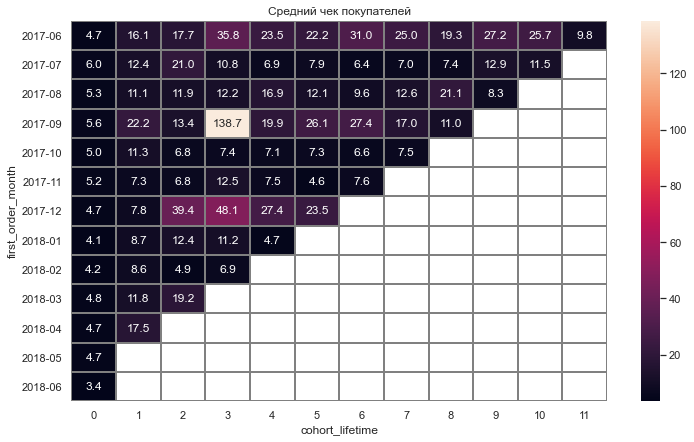

In [221]:
plt.figure(figsize=(12,7))
plt.title('Средний чек покупателей')
sns.heatmap(avr_money(month(merge_table(first_activity_date(visits)))),\
            annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

In [94]:
('Общий чек по всей выборке {}'.format(orders['revenue'].mean()))

'Общий чек по всей выборке 4.999646930477041'


Несмотря на то, что в некоторых когортах в определенный месяц ее жизни средний чек достигает довольно высокое значение, к примеру в когорте 2017-09 к 4 месяцу (138.7), средний чек по всей выборке остается довольно низким.


Видно, в первой когорте средний чек вырос к 4 месяцу жизни и к 7 месяцу жизни. В первой когорте средний чек покупателя держался на протяжении всего времени довольно хорошо.
В когорте 2017 - 09 средний чек очень вырос к 4 месяцу жизни, это как раз период предновогожней закупки подарков.

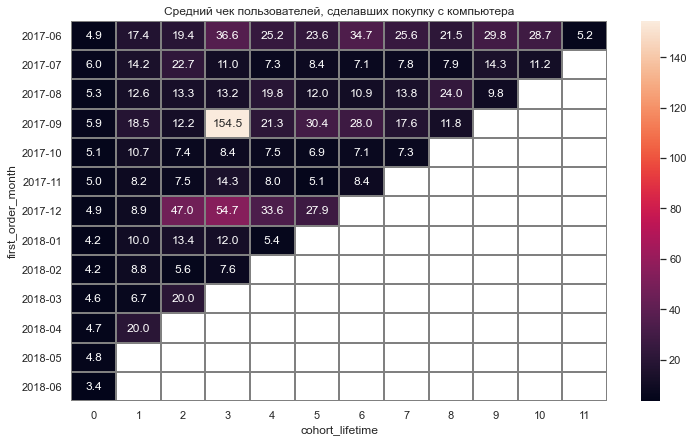

In [222]:
plt.figure(figsize=(12,7))
plt.title('Средний чек пользователей, сделавших покупку с компьютера')
sns.heatmap(avr_money(month(merge_table(first_activity_date(desktop)))),\
            annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

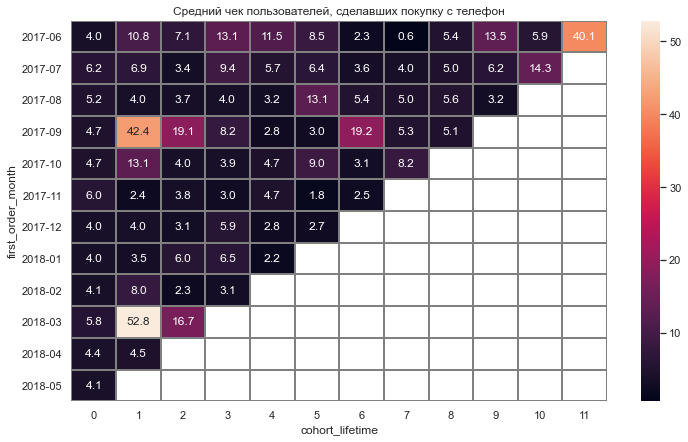

In [223]:
plt.figure(figsize=(12,7))
plt.title('Средний чек пользователей, сделавших покупку с телефон')
sns.heatmap(avr_money(month(merge_table(first_activity_date(touch)))),\
            annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()


Средний чек покупок, сделанных с компьютера выше, это может доказывать предположение о том, что версия сайта для телефона или планшета не совсем удобная, для совершения покупки. Но в некоторые месяца средний чек пользователей по когорте выше, чем у пользователь, которые делали покупку с компьютера. Например, в первой когорте 2017-06 к 11 месяцу жизни средний чек среди тех, кто покупал с мобильного устройства выше, чем с компьютера *(40.1 > 5.2)*. Аналогичная ситуация в  2017-09, 2 месяц жизни *(42.4 > 18.5)*, 2018-03, 2 месяц жизни *(52.8 > 6.7)*

---

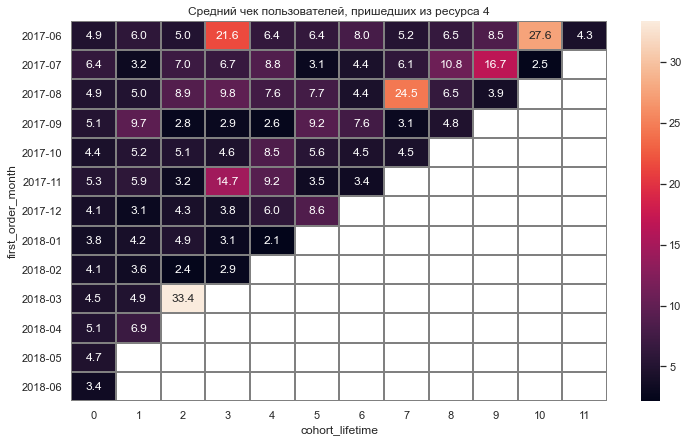

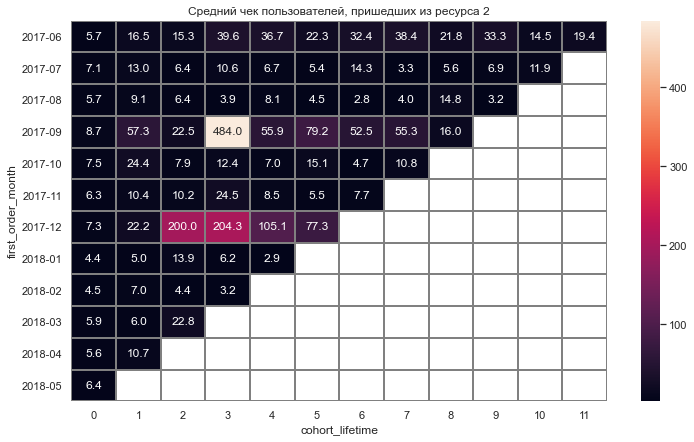

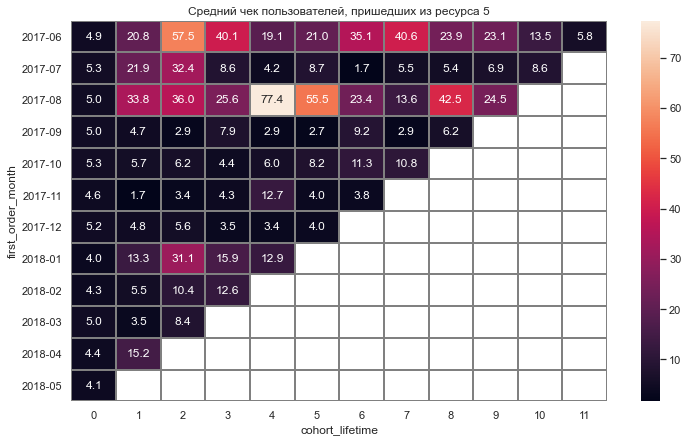

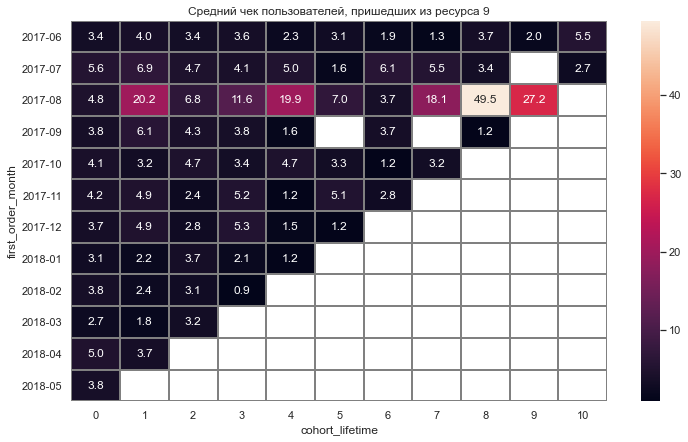

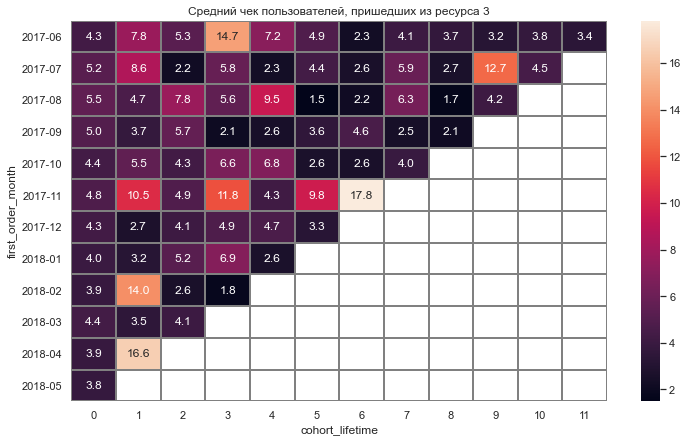

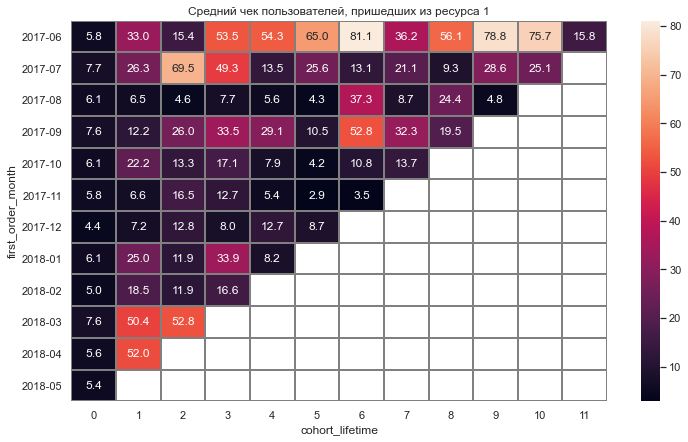

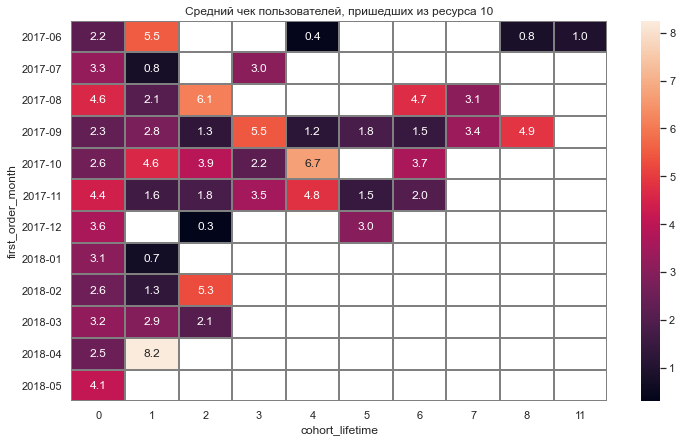

In [224]:
for source in visits_m['first_source_id'].unique():
    first_source_visits = visits[visits['first_source_id'] == source]
    
    plt.figure(figsize=(12,7))
    plt.title('Средний чек пользователей, пришедших из ресурса {}'.format(source))
    sns.heatmap(avr_money(month(merge_table(first_activity_date(first_source_visits)))),\
            annot=True, fmt='.1f', linewidths=1, linecolor='gray')
    plt.show()

Самые высокие показатели сренего чека у второго ресурса(2017-09 к 4 месяцу - 484),(2017-12 с 3 по 5 месяц сохраняется высокое знаение среднего чека в диапазоне 15-200). Средний чек у пользователей, пришедших на сайт с ресурсов 1, 5 имеет неплохой показатель ( в пределах 80) среди когорт.
У первого ресурса первой и второй когорты сохраняется довольно высокое значение в течении времени жизни когорты, по сравнению с остальными.

---

<a id='ltv'></a>
Найду **LTV**.

In [98]:
def ltv(first_orders):
    cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    orders_new = pd.merge(first_orders,cohort_sizes, on='first_order_month')
    0
    cohorts = orders_new.groupby(['first_order_month','order_month']).\
    agg({'revenue': 'sum'}).reset_index()
    report = pd.merge(cohorts, cohort_sizes, on='first_order_month')
    report['age'] = (report['order_month'] - report['first_order_month']) \
    / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype(int)
    report['ltv'] = report['revenue'] / report['n_buyers']
    return report

In [99]:
ltv(month(merge_table(first_activity_date(visits))))

first_order_month order_month   revenue  n_buyers  age       ltv
0         2017-06-01  2017-06-01   9557.49      2023    0  4.724414
1         2017-06-01  2017-07-01    981.82      2023    1  0.485329
2         2017-06-01  2017-08-01    885.34      2023    2  0.437637
3         2017-06-01  2017-09-01   1931.30      2023    3  0.954671
4         2017-06-01  2017-10-01   2068.58      2023    4  1.022531
..               ...         ...       ...       ...  ...       ...
74        2018-03-01  2018-05-01   1114.87      3533    2  0.315559
75        2018-04-01  2018-04-01  10600.69      2276    0  4.657597
76        2018-04-01  2018-05-01   1209.92      2276    1  0.531599
77        2018-05-01  2018-05-01  13925.76      2988    0  4.660562
78        2018-06-01  2018-06-01      3.42         1    0  3.420000

[79 rows x 6 columns]

In [100]:
output = ltv(month(merge_table(first_activity_date(visits)))).\
pivot_table(index='first_order_month',
            columns='age',
            values = 'ltv',
            aggfunc='mean').cumsum(axis=1).round(2)

output.fillna("")

age                  0     1     2      3      4      5      6      7      8   \
first_order_month                                                               
2017-06-01         4.72  5.21  5.65    6.6   7.62   8.36   9.31   9.89  10.45   
2017-07-01         6.01  6.35  6.97   7.33    7.5   7.66   7.78   7.92   8.08   
2017-08-01         5.28  5.75  6.21    6.6   7.09   7.38   7.59   7.99   8.28   
2017-09-01         5.64  6.76  7.28  11.26  11.66  12.31  13.01  13.25  13.44   
2017-10-01         5.00  5.54  5.73   5.89   6.04   6.16   6.24   6.36          
2017-11-01         5.15  5.55  5.75   6.08   6.23   6.28    6.4                 
2017-12-01         4.74     5  5.92   6.99    7.3   7.64                        
2018-01-01         4.14  4.43  4.73   4.88   4.94                               
2018-02-01         4.16  4.44  4.51   4.59                                      
2018-03-01         4.84  5.14  5.46                                             
2018-04-01         4.66  5.19                                                   
2018-05-01         4.66                                                         
2018-06-01         3.42                                                         

age                   9      10     11  
first_order_month                       
2017-06-01         11.05  11.62  11.88  
2017-07-01          8.23   8.39         
2017-08-01          8.47                
2017-09-01                              
2017-10-01                              
2017-11-01                              
2017-12-01                              
2018-01-01                              
2018-02-01                              
2018-03-01                              
2018-04-01                              
2018-05-01                              
2018-06-01

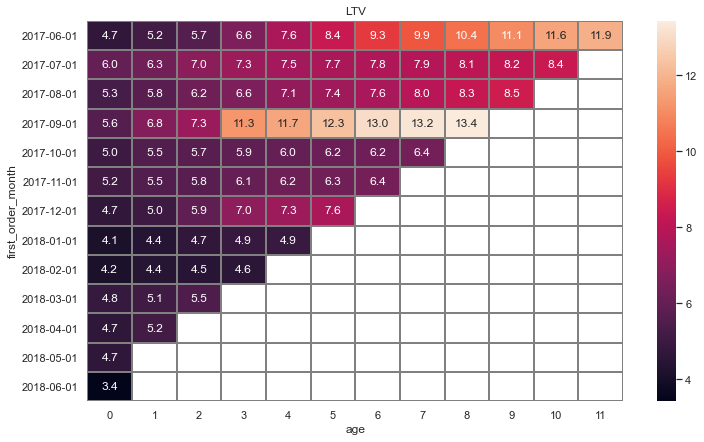

In [101]:
output_ltv_one = ltv(month(merge_table(first_activity_date(visits))))
output_ltv_one['first_order_month'] = output_ltv_one['first_order_month'].dt.date
output = output_ltv_one.pivot_table(index='first_order_month',
                                    columns='age',
                                    values = 'ltv',
                                    aggfunc='mean').cumsum(axis=1).round(2)

plt.figure(figsize=(12,7))
plt.title('LTV')
sns.heatmap(output,annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

У когорты 2017-09-01 размер прибыли, которую приносит один клиент в среднем выше, чем у остальных. У когорты 2017-06-01 показатели тоже довольно высокие.

In [102]:
source_orders = month(merge_table(first_activity_date(visits))).merge(visits_first, on='uid')

In [103]:
source_orders

order_date  revenue                   uid first_activity_date  \
0     2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 00:09:00   
1     2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 00:14:00   
2     2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 00:25:00   
3     2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 00:14:00   
4     2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 07:31:00   
...                   ...      ...                   ...                 ...   
50410 2018-05-31 23:50:00     4.64  12296626599487328624 2018-05-31 09:11:00   
50411 2018-05-31 23:50:00     5.80  11369640365507475976 2018-05-31 23:05:00   
50412 2018-05-31 23:54:00     0.30   1786462140797698849 2018-05-31 23:52:00   
50413 2018-05-31 23:56:00     3.67   3993697860786194247 2017-10-23 12:32:00   
50414 2018-06-01 00:02:00     3.42     83872787173869366 2018-05-31 23:59:00   

         first_order_date  year  month first_order_month order_month  \
0     2017-06-01 00:10:00  2017      6        2017-06-01  2017-06-01   
1     2017-06-01 00:25:00  2017      6        2017-06-01  2017-06-01   
2     2017-06-01 00:27:00  2017      6        2017-06-01  2017-06-01   
3     2017-06-01 00:29:00  2017      6        2017-06-01  2017-06-01   
4     2017-06-01 07:58:00  2017      6        2017-06-01  2017-06-01   
...                   ...   ...    ...               ...         ...   
50410 2018-05-31 23:50:00  2018      5        2018-05-01  2018-05-01   
50411 2018-05-31 23:50:00  2018      5        2018-05-01  2018-05-01   
50412 2018-05-31 23:54:00  2018      5        2018-05-01  2018-05-01   
50413 2018-05-31 23:56:00  2018      5        2018-05-01  2018-05-01   
50414 2018-06-01 00:02:00  2018      6        2018-06-01  2018-06-01   

      first_source_id  
0                   1  
1                   2  
2                   2  
3                   2  
4                   3  
...               ...  
50410               4  
50411              10  
50412               3  
50413               4  
50414               4  

[50415 rows x 10 columns]

In [104]:
def source_LTV(source_orders):
    cohort_sizes = source_orders.groupby(['first_source_id', 'order_month']).agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_source_id','order_month', 'n_buyers']
    orders_new = pd.merge(source_orders,cohort_sizes, on=['first_source_id', 'order_month'])
    
    cohorts = orders_new.groupby(['first_source_id','order_month']).agg({'revenue': 'sum'}).reset_index()
    report_ltv = pd.merge(cohorts, cohort_sizes, on=['first_source_id','order_month'])

    report_ltv['ltv'] = report_ltv['revenue'] / report_ltv['n_buyers']
    
    return report_ltv


In [105]:
source_LTV(source_orders)

first_source_id order_month  revenue  n_buyers        ltv
0                1  2017-06-01  1168.45       203   5.755911
1                1  2017-07-01  1985.01       222   8.941486
2                1  2017-08-01  1251.84       163   7.680000
3                1  2017-09-01  3730.05       316  11.803956
4                1  2017-10-01  3772.12       454   8.308634
..             ...         ...      ...       ...        ...
81               9  2018-01-01   518.29       155   3.343806
82               9  2018-02-01   585.55       156   3.753526
83               9  2018-03-01   754.09       247   3.052996
84               9  2018-04-01   500.74        78   6.419744
85               9  2018-05-01   347.45        85   4.087647

[86 rows x 5 columns]

In [106]:
source_ltv = source_LTV(source_orders).pivot_table(index='first_source_id',
                columns='order_month',
                values = 'ltv',
                aggfunc='mean').round(2).cumsum(axis=1)
source_ltv.fillna('')

order_month     2017-06-01 2017-07-01  2017-08-01 2017-09-01 2017-10-01  \
first_source_id                                                           
1                     5.76       14.7       22.38      34.18      42.49   
10                    2.22       5.57       10.00      12.29      14.92   
2                     5.73      13.43       20.52      30.84      42.67   
3                      4.3       9.55       15.14      20.22      24.67   
4                     4.89      11.27       16.16      21.45      26.03   
5                     4.86      10.46       16.84      22.79      28.61   
7                                            1.22                         
9                      3.4       8.89       13.76       18.2      22.53   

order_month     2017-11-01 2017-12-01 2018-01-01 2018-02-01 2018-03-01  \
first_source_id                                                          
1                    50.91       58.3      66.37      74.13      84.85   
10                   19.23      22.85       25.9      28.47      31.65   
2                    51.74      75.17      84.11      99.42     116.04   
3                    29.52      34.03      38.03      42.11      46.69   
4                    31.33      35.64      39.46      44.07      48.99   
5                    33.68      39.54      44.02      49.01      55.09   
7                                                                        
9                    26.78      30.64      33.98      37.73      40.78   

order_month     2018-04-01 2018-05-01 2018-06-01  
first_source_id                                   
1                    96.37     105.14             
10                   34.24      38.27             
2                   126.09     135.43             
3                     50.6      54.72             
4                    54.25      59.32      62.74  
5                    60.12      65.06             
7                                                 
9                     47.2      51.29

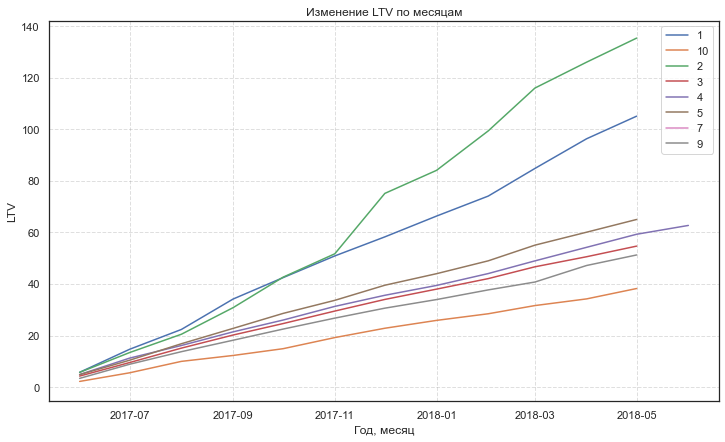

In [107]:
plt.figure(figsize=(12,7))
for source in range(0, len(source_ltv.index)):
    date_inter = source_ltv.loc[source_ltv.index[source]].reset_index()
    plt.plot(date_inter['order_month'], date_inter[date_inter.columns[1]], label=source_ltv.index[source])
    plt.grid(True, linestyle='--', color='grey', which='major', alpha=.25)
    plt.legend()
plt.title('Изменение LTV по месяцам')
plt.xlabel('Год, месяц')
plt.ylabel('LTV')
plt.show()


 Наиболее прибыльный является 2 ресурс. Показатель LTV в каждый месяц чаще находится выше, чем у остальных ресурсов. Первый ресурс до 2017-09 имел схожие показатели LTV, что и 2, но потом он не особо изменял свой показаетль, в то время как у 2 ресурса был скачек в 12 месяце 2017 года. Пожизненная стоимость покупателя у остальных ресурсов сохраняет довольно стабильное положение. Самый низкий показатель LTV имеет 10 ресурс.

---

#### 3. Таблица costs

<a id='overallcost'></a>
Посмотрю, сколько потратили денег всего/на каждый источник/по времени

In [108]:
print('{} потратили всего на привлечение пользователей'.format(costs['costs'].sum()))

329131.62 потратили всего на привлечение пользователей


In [109]:
grouped_source=costs.groupby('source_id')['costs'].sum().reset_index().\
sort_values(by='costs',ascending=False)

In [110]:
grouped_source

source_id      costs
3         3  141321.63
4         4   61073.60
5         5   51757.10
2         2   42806.04
0         1   20833.27
1        10    5822.49
6         9    5517.49

В третий ресур маркетологи вложили больше всего денег.

In [111]:
grouped_date = costs.groupby('date')['costs'].sum().reset_index().\
sort_values(by='costs',ascending=False)

In [112]:
grouped_date.head()

date    costs
176 2017-11-24  3458.86
363 2018-05-31  2153.70
193 2017-12-11  2121.13
254 2018-02-10  1981.39
168 2017-11-16  1811.02

Можно попробовать сопоставить высокие значения пользователей, пришедших на сайт и сделавших покупку, с вложениями.

In [113]:
dau_total[dau_total['uid'] == 3319]

date  week   uid
176  2017-11-24    47  3319

Больше всего посещений было 24 ноября 2017 года. В этот день отдел маркетинга вложил больше всего денег. Но, я не могу утверждать, что именно эти вложенния принесли столько пользователей, так как может быть и так, что это были пользователи, которые пришли с других источников и более раннего времени.

In [114]:
costs[costs['date'] == '2017-11-24']

source_id       date    costs
176          1 2017-11-24   245.75
539          2 2017-11-24   507.09
902          3 2017-11-24  1788.28
1265         4 2017-11-24    80.88
1628         5 2017-11-24   719.22
1992         9 2017-11-24    49.53
2355        10 2017-11-24    68.11

В 3 ресурс было вложено больше всего денег за все время, также видно, что 2017-11-24, в 3 ресурс было также вложено больше, чем в остальные ресурсы.

In [115]:
costs['month'] = costs['date'].astype('datetime64[M]')
monthly_costs = costs.groupby('month').sum().reset_index()

In [116]:
monthly_costs

month     costs
0  2017-06-01  18015.00
1  2017-07-01  18240.59
2  2017-08-01  14790.54
3  2017-09-01  24368.91
4  2017-10-01  36322.88
5  2017-11-01  37907.88
6  2017-12-01  38315.35
7  2018-01-01  33518.52
8  2018-02-01  32723.03
9  2018-03-01  30415.27
10 2018-04-01  22289.38
11 2018-05-01  22224.27

In [117]:
costs_per_source = costs.pivot_table(index='source_id',
                 columns='month',
                 values='costs',
                 aggfunc='sum').round(2)
costs_per_source

month      2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
source_id                                                               
1             1125.61     1072.88      951.81     1502.01     2315.75   
10             314.22      329.82      232.57      460.67      627.24   
2             2427.38     2333.11     1811.05     2985.66     4845.00   
3             7731.65     7674.37     6143.54     9963.55    15737.24   
4             3514.80     3529.73     3217.36     5192.26     6420.84   
5             2616.12     2998.14     2185.28     3849.14     5767.40   
9              285.22      302.54      248.93      415.62      609.41   

month      2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
source_id                                                               
1             2445.16     2341.20     2186.18     2204.48     1893.09   
10             792.36      645.86      614.35      480.88      526.41   
2             5247.68     4897.80     4157.74     4474.34     3943.14   
3            17025.34    16219.52    14808.78    14228.56    13080.85   
4             5388.82     7680.47     5832.79     5711.96     5961.87   
5             6325.34     5872.52     5371.52     5071.31     4529.62   
9              683.18      657.98      547.16      551.50      480.29   

month      2018-04-01  2018-05-01  
source_id                          
1             1327.49     1467.61  
10             388.25      409.86  
2             2993.70     2689.44  
3             9296.81     9411.42  
4             4408.49     4214.21  
5             3501.15     3669.56  
9              373.49      362.17

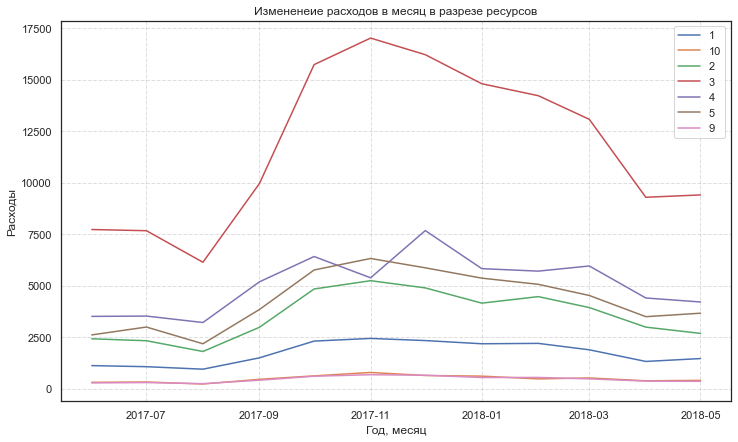

In [118]:
plt.figure(figsize=(12,7))
for source in range(0, len(costs_per_source.index)):
    date_inter = costs_per_source.loc[costs_per_source.index[source]].reset_index()
    plt.plot(date_inter['month'], date_inter[date_inter.columns[1]], label=costs_per_source.index[source])
    plt.legend()
plt.title('Измененеие расходов в месяц в разрезе ресурсов')
plt.xlabel('Год, месяц')
plt.ylabel('Расходы')
plt.grid(True, linestyle='--', color='grey', which='major', alpha=.25)


По графику можно сделать вывод, что большая часть вложений пошла на 3 ресурс. Меньше всего - на 9 ресурс.

---

<a id='cacromi'></a>
Посчитаю **СAC и ROMI** всех когорт и найду их среднее значение.

In [119]:
def cac_romi(report):
    report_new = pd.merge(report, monthly_costs, left_on='first_order_month',right_on ='month')
    report_new['cac'] = report_new['costs'] / report_new['n_buyers']
    report_new['romi'] = report_new['ltv'] / report_new['cac']
    
    report_new['first_order_month'] = report_new['first_order_month'].dt.date
    return report_new

In [120]:
cac_romi(ltv(month(merge_table(first_activity_date(visits))))).head()

first_order_month order_month  revenue  n_buyers  age       ltv      month  \
0        2017-06-01  2017-06-01  9557.49      2023    0  4.724414 2017-06-01   
1        2017-06-01  2017-07-01   981.82      2023    1  0.485329 2017-06-01   
2        2017-06-01  2017-08-01   885.34      2023    2  0.437637 2017-06-01   
3        2017-06-01  2017-09-01  1931.30      2023    3  0.954671 2017-06-01   
4        2017-06-01  2017-10-01  2068.58      2023    4  1.022531 2017-06-01   

     costs       cac      romi  
0  18015.0  8.905091  0.530530  
1  18015.0  8.905091  0.054500  
2  18015.0  8.905091  0.049145  
3  18015.0  8.905091  0.107205  
4  18015.0  8.905091  0.114825


Таблица с значениями CAC:


In [121]:
output_cac = cac_romi(ltv(month(merge_table(first_activity_date(visits)))))\
.pivot_table(index='first_order_month',
             columns='age',
             values='cac',
             aggfunc='mean').round(2)
output_cac.fillna('')

age                   0     1     2     3     4     5     6     7     8   \
first_order_month                                                          
2017-06-01          8.91  8.91  8.91  8.91  8.91  8.91  8.91  8.91  8.91   
2017-07-01          9.49  9.49  9.49  9.49  9.49  9.49  9.49  9.49  9.49   
2017-08-01         10.80  10.8  10.8  10.8  10.8  10.8  10.8  10.8  10.8   
2017-09-01          9.44  9.44  9.44  9.44  9.44  9.44  9.44  9.44  9.44   
2017-10-01          8.37  8.37  8.37  8.37  8.37  8.37  8.37  8.37         
2017-11-01          9.29  9.29  9.29  9.29  9.29  9.29  9.29               
2017-12-01          8.74  8.74  8.74  8.74  8.74  8.74                     
2018-01-01          9.94  9.94  9.94  9.94  9.94                           
2018-02-01          8.96  8.96  8.96  8.96                                 
2018-03-01          8.61  8.61  8.61                                       
2018-04-01          9.79  9.79                                             
2018-05-01          7.44                                                   

age                  9     10    11  
first_order_month                    
2017-06-01         8.91  8.91  8.91  
2017-07-01         9.49  9.49        
2017-08-01         10.8              
2017-09-01                           
2017-10-01                           
2017-11-01                           
2017-12-01                           
2018-01-01                           
2018-02-01                           
2018-03-01                           
2018-04-01                           
2018-05-01

In [122]:
output = cac_romi(ltv(month(merge_table(first_activity_date(visits)))))\
.pivot_table(index='first_order_month',
             columns='age',
             values='romi',
             aggfunc='mean').cumsum(axis=1).round(2)

output.fillna('')

age                  0     1     2     3     4     5     6     7     8     9   \
first_order_month                                                               
2017-06-01         0.53  0.59  0.63  0.74  0.86  0.94  1.05  1.11  1.17  1.24   
2017-07-01         0.63  0.67  0.73  0.77  0.79  0.81  0.82  0.84  0.85  0.87   
2017-08-01         0.49  0.53  0.57  0.61  0.66  0.68   0.7  0.74  0.77  0.78   
2017-09-01         0.60  0.72  0.77  1.19  1.23   1.3  1.38   1.4  1.42         
2017-10-01         0.60  0.66  0.68   0.7  0.72  0.74  0.75  0.76               
2017-11-01         0.55   0.6  0.62  0.65  0.67  0.68  0.69                     
2017-12-01         0.54  0.57  0.68   0.8  0.84  0.87                           
2018-01-01         0.42  0.45  0.48  0.49   0.5                                 
2018-02-01         0.46  0.49   0.5  0.51                                       
2018-03-01         0.56   0.6  0.63                                             
2018-04-01         0.48  0.53                                                   
2018-05-01         0.63                                                         

age                  10    11  
first_order_month              
2017-06-01         1.31  1.33  
2017-07-01         0.88        
2017-08-01                     
2017-09-01                     
2017-10-01                     
2017-11-01                     
2017-12-01                     
2018-01-01                     
2018-02-01                     
2018-03-01                     
2018-04-01                     
2018-05-01

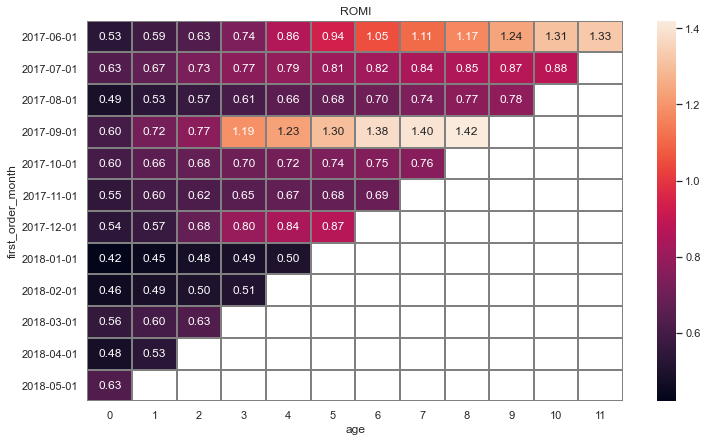

In [123]:
plt.figure(figsize=(12,7))
sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title('ROMI')
plt.show()

Окупились:
* Июньская когорта на 8 месяц (ROMI=1.11)
* Сентябрьская когорта на 4 месяц (ROMI=1.19)



Остальные не окупились, но многие когорты были близки к этому, например июльская когорта ( через месяца 2), августовская, январьская.

---

In [124]:
amount_month = []
for cohort in range(0, len(output.index)):
    inter_date = output.loc[output.index[cohort]].reset_index()
    len_month = len(inter_date[inter_date[inter_date.columns[1]] < 1])
    amount_month.append(len_month)
print('Среднее количество месяцев до окупаемости когорты {}'.format(np.mean(amount_month)))

Среднее количество месяцев до окупаемости когорты 5.5


In [125]:
source_costs = costs.groupby(['source_id', 'month'])['costs'].sum().reset_index()
source_costs.columns = ['first_source_id', 'order_month', 'costs']
source_costs.head(10)

first_source_id order_month    costs
0               1  2017-06-01  1125.61
1               1  2017-07-01  1072.88
2               1  2017-08-01   951.81
3               1  2017-09-01  1502.01
4               1  2017-10-01  2315.75
5               1  2017-11-01  2445.16
6               1  2017-12-01  2341.20
7               1  2018-01-01  2186.18
8               1  2018-02-01  2204.48
9               1  2018-03-01  1893.09

In [229]:
source_LTV(source_orders)

first_source_id order_month  revenue  n_buyers        ltv
0                1  2017-06-01  1168.45       203   5.755911
1                1  2017-07-01  1985.01       222   8.941486
2                1  2017-08-01  1251.84       163   7.680000
3                1  2017-09-01  3730.05       316  11.803956
4                1  2017-10-01  3772.12       454   8.308634
..             ...         ...      ...       ...        ...
81               9  2018-01-01   518.29       155   3.343806
82               9  2018-02-01   585.55       156   3.753526
83               9  2018-03-01   754.09       247   3.052996
84               9  2018-04-01   500.74        78   6.419744
85               9  2018-05-01   347.45        85   4.087647

[86 rows x 5 columns]

In [126]:
source_orders

order_date  revenue                   uid first_activity_date  \
0     2017-06-01 00:10:00    17.00  10329302124590727494 2017-06-01 00:09:00   
1     2017-06-01 00:25:00     0.55  11627257723692907447 2017-06-01 00:14:00   
2     2017-06-01 00:27:00     0.37  17903680561304213844 2017-06-01 00:25:00   
3     2017-06-01 00:29:00     0.55  16109239769442553005 2017-06-01 00:14:00   
4     2017-06-01 07:58:00     0.37  14200605875248379450 2017-06-01 07:31:00   
...                   ...      ...                   ...                 ...   
50410 2018-05-31 23:50:00     4.64  12296626599487328624 2018-05-31 09:11:00   
50411 2018-05-31 23:50:00     5.80  11369640365507475976 2018-05-31 23:05:00   
50412 2018-05-31 23:54:00     0.30   1786462140797698849 2018-05-31 23:52:00   
50413 2018-05-31 23:56:00     3.67   3993697860786194247 2017-10-23 12:32:00   
50414 2018-06-01 00:02:00     3.42     83872787173869366 2018-05-31 23:59:00   

         first_order_date  year  month first_order_month order_month  \
0     2017-06-01 00:10:00  2017      6        2017-06-01  2017-06-01   
1     2017-06-01 00:25:00  2017      6        2017-06-01  2017-06-01   
2     2017-06-01 00:27:00  2017      6        2017-06-01  2017-06-01   
3     2017-06-01 00:29:00  2017      6        2017-06-01  2017-06-01   
4     2017-06-01 07:58:00  2017      6        2017-06-01  2017-06-01   
...                   ...   ...    ...               ...         ...   
50410 2018-05-31 23:50:00  2018      5        2018-05-01  2018-05-01   
50411 2018-05-31 23:50:00  2018      5        2018-05-01  2018-05-01   
50412 2018-05-31 23:54:00  2018      5        2018-05-01  2018-05-01   
50413 2018-05-31 23:56:00  2018      5        2018-05-01  2018-05-01   
50414 2018-06-01 00:02:00  2018      6        2018-06-01  2018-06-01   

      first_source_id  
0                   1  
1                   2  
2                   2  
3                   2  
4                   3  
...               ...  
50410               4  
50411              10  
50412               3  
50413               4  
50414               4  

[50415 rows x 10 columns]

In [230]:
def cac_romi_resource(report):
    report_new = pd.merge(report, source_costs, on = ['first_source_id','order_month'])
    report_new['cac'] = report_new['costs'] / report_new['n_buyers']
    report_new['romi'] = report_new['ltv'] / report_new['cac']
    report_new['order_month'] = report_new['order_month'].dt.date
    
    return report_new

In [231]:
cac_romi_resource(source_LTV(source_orders))

first_source_id order_month  revenue  n_buyers        ltv    costs  \
0                1  2017-06-01  1168.45       203   5.755911  1125.61   
1                1  2017-07-01  1985.01       222   8.941486  1072.88   
2                1  2017-08-01  1251.84       163   7.680000   951.81   
3                1  2017-09-01  3730.05       316  11.803956  1502.01   
4                1  2017-10-01  3772.12       454   8.308634  2315.75   
..             ...         ...      ...       ...        ...      ...   
79               9  2018-01-01   518.29       155   3.343806   547.16   
80               9  2018-02-01   585.55       156   3.753526   551.50   
81               9  2018-03-01   754.09       247   3.052996   480.29   
82               9  2018-04-01   500.74        78   6.419744   373.49   
83               9  2018-05-01   347.45        85   4.087647   362.17   

         cac      romi  
0   5.544877  1.038059  
1   4.832793  1.850170  
2   5.839325  1.315220  
3   4.753196  2.483372  
4   5.100771  1.628898  
..       ...       ...  
79  3.530065  0.947237  
80  3.535256  1.061741  
81  1.944494  1.570072  
82  4.788333  1.340705  
83  4.260824  0.959356  

[84 rows x 8 columns]


CAC в разрезе ресурсов


In [129]:
output_cac_source = cac_romi_resource(source_LTV(source_orders))\
.pivot_table(index='first_source_id',
             columns='order_month',
             values='cac',
             aggfunc='mean').round(2)
output_cac_source.fillna('')

order_month      2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
first_source_id                                                               
1                      5.54        4.83        5.84        4.75        5.10   
10                     3.61        6.87        5.96        6.58        3.18   
2                      8.96        8.51        9.95        8.36        8.25   
3                     13.47       16.94       20.08       14.96       14.48   
4                      8.43        7.13        9.27        8.43        5.50   
5                      7.11        7.28        6.35        6.37        5.90   
9                      2.77        3.78        2.77        3.43        2.97   

order_month      2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
first_source_id                                                               
1                      4.78        4.31        5.41        5.29        4.22   
10                     6.60        7.34        6.75        3.51        2.77   
2                      8.26        7.76        9.22        9.02        7.64   
3                     15.37       13.15       15.82       13.13       13.58   
4                      4.41        5.29        5.10        4.79        5.09   
5                      8.81        7.29        7.48        6.54        7.03   
9                      2.93        3.50        3.53        3.54        1.94   

order_month      2018-04-01  2018-05-01  
first_source_id                          
1                      4.30        3.72  
10                     3.16        3.18  
2                      8.60        4.71  
3                     15.24       10.65  
4                      5.69        4.72  
5                      6.99        6.23  
9                      4.79        4.26

In [130]:
plt.figure(figsize=(15,7))
sns.heatmap(output_cac_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title('CAC в разрезе источников')
plt.show()


Больше всего вложили денег на привлечение клиентов в 3 ресурсе, причем 2017-08 вложились больше, чем в остальные месяцы.


In [131]:

output_romi_source = cac_romi_resource(source_LTV(source_orders))\
.pivot_table(index='first_source_id',
             columns='order_month',
             values='romi',
             aggfunc='mean').cumsum(axis=1).round(2)
output_romi_source.fillna('')

order_month      2017-06-01  2017-07-01  2017-08-01  2017-09-01  2017-10-01  \
first_source_id                                                               
1                      1.04        2.89        4.20        6.69        8.32   
10                     0.61        1.10        1.84        2.19        3.02   
2                      0.64        1.54        2.26        3.49        4.92   
3                      0.32        0.63        0.91        1.25        1.55   
4                      0.58        1.47        2.00        2.63        3.46   
5                      0.68        1.45        2.46        3.39        4.38   
9                      1.23        2.68        4.44        5.73        7.19   

order_month      2017-11-01  2017-12-01  2018-01-01  2018-02-01  2018-03-01  \
first_source_id                                                               
1                     10.08       11.79       13.29       14.75       17.30   
10                     3.67        4.16        4.61        5.35        6.49   
2                      6.02        9.04       10.01       11.71       13.88   
3                      1.87        2.21        2.47        2.78        3.11   
4                      4.67        5.48        6.23        7.19        8.16   
5                      4.95        5.76        6.36        7.12        7.98   
9                      8.64        9.75       10.69       11.75       13.32   

order_month      2018-04-01  2018-05-01  
first_source_id                          
1                     19.98       22.33  
10                     7.31        8.58  
2                     15.05       17.03  
3                      3.37        3.76  
4                      9.08       10.16  
5                      8.70        9.49  
9                     14.67       15.62

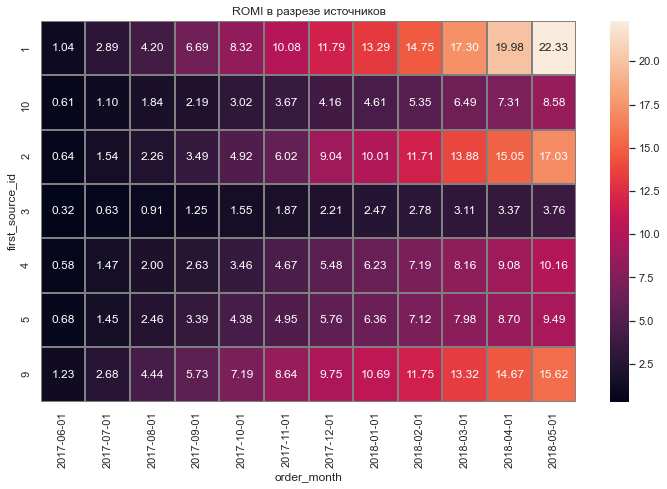

In [132]:
plt.figure(figsize=(12,7))
sns.heatmap(output_romi_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title('ROMI в разрезе источников')
plt.show()


Вложения в 1 источник окупились через 6 месяцев, во 2 источник - через 8 месяцев, в 9 - через 9 месяцев.
    Такие источники, как 4,5,10 близки к окупаемости. Источник 3 имеет очень низкий Romi даже под через 11 месяцев.



На 2018-05 видно, что больше всего вложились в 3 ресурс, но он имеет наименьший показатель окупаемости.


<a id='conclusion'></a>
### Шаг 4. Построение графиков. Вывод

Я изучила датасеты, оптимизировала данные для анализа, поменяла тип данных для идентификаторов и дат.

**DAU, WAU и MAU**

Были подсчитаны метрики  DAU, WAU и MAU, и сделан вывод, что в день, в неделю, в месяц, в среднем больше на сайт заходят пользователи, которые пользуются компьютером, нежелени чем телефоном или планшетом. 

907 сессий в среднем в день у сайта Яндекс Афиша

С компьютера в 2.6 раза чаще люди заходят на сайт Яндекс Афиши, чем с телефона в среднем в день.

Средняя продолжительность сессии и на телефоне/планшете и на компьютере - 60 секунд.

**Метрика Retention Rate**

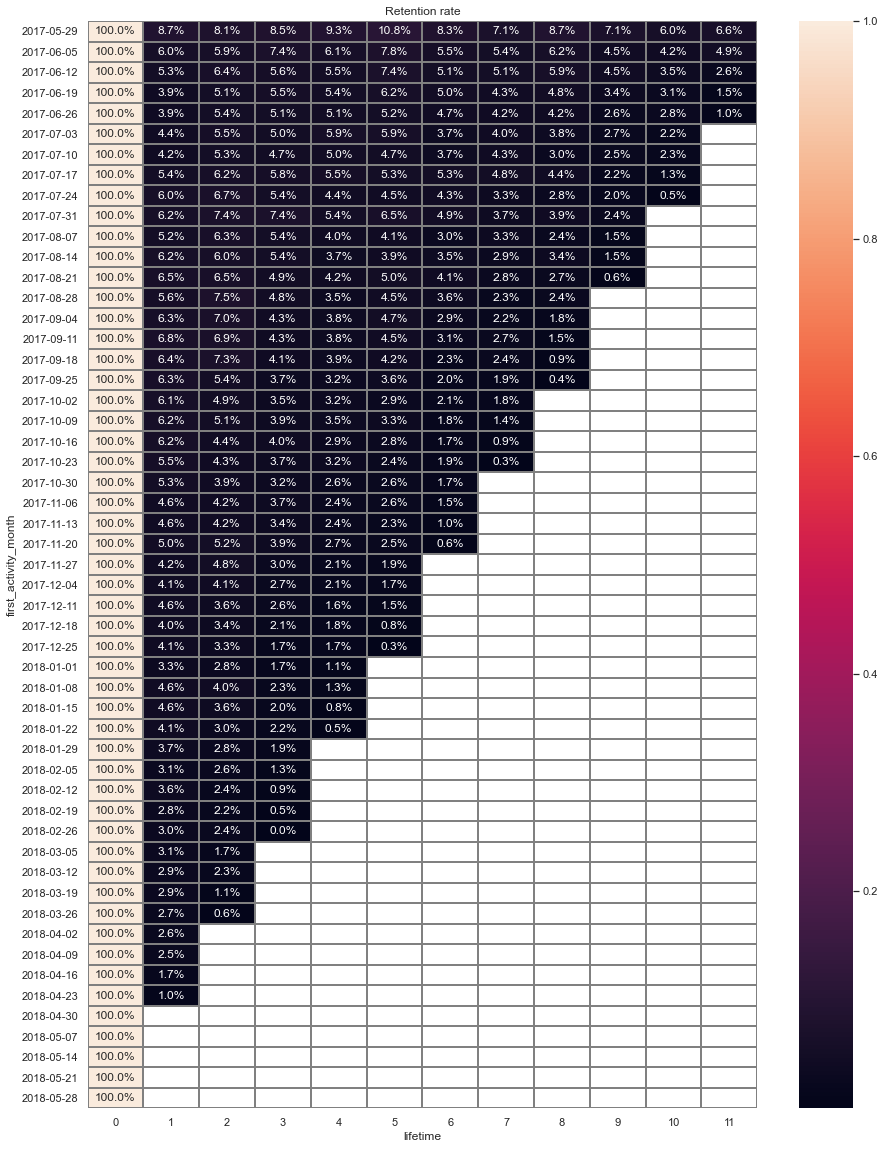

In [133]:
sns.set(style='white')
plt.figure(figsize=(15,20))
plt.title('Retention rate')
sns.heatmap(retention_rate(first_activity(visits)), annot=True, fmt='.1%',\
            linewidth=1, linecolor='grey')
plt.show()

У первой когорты достаточно высокий Retention Rate, со временем он упал, конечно, но из всех когорот он сохранял не плохие показатели в течении времени. У второй когорты Retention rate сохраняет стабильные показатели в течении времени. К 6 месяцу жизни у когорт до 2017-07-10 поднимается этот показатель, потом падает.

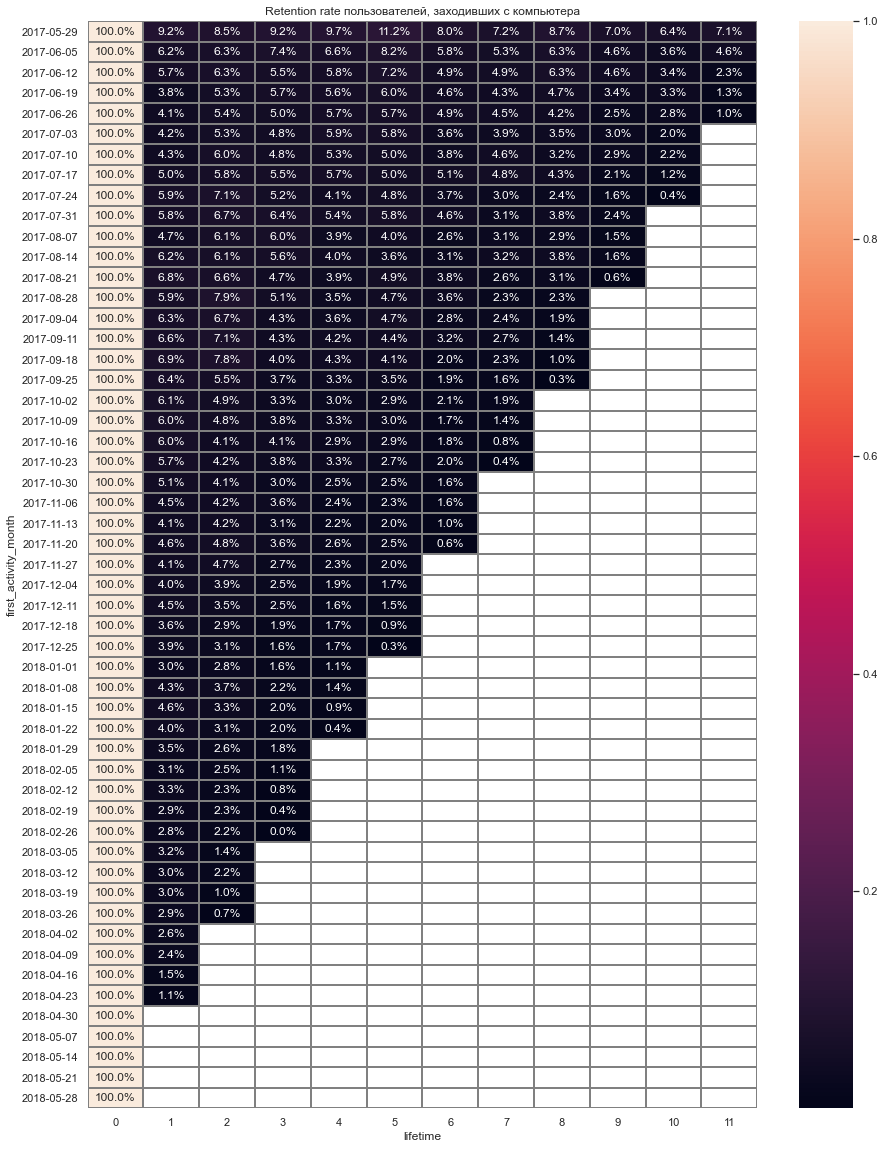

In [134]:
sns.set(style='white')
plt.figure(figsize=(15,20))
plt.title('Retention rate пользователей, заходивших с компьютера')
sns.heatmap(retention_rate(first_activity(desktop_visits)), annot=True, fmt='.1%',\
            linewidth=1, linecolor='grey')
plt.show()

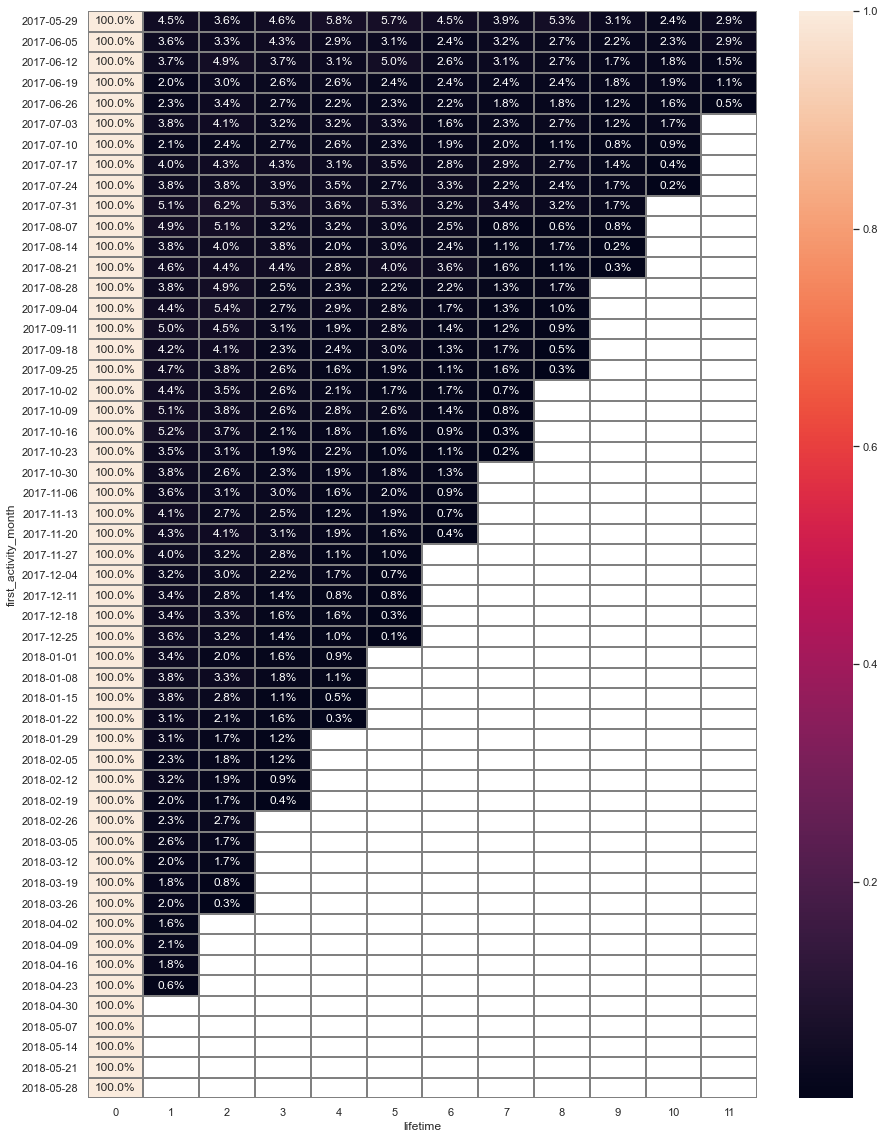

In [135]:
sns.set(style='white')
plt.figure(figsize=(15,20))
sns.heatmap(retention_rate(first_activity(touch_visits)), annot=True, fmt='.1%',\
            linewidth=1, linecolor='grey')
plt.show()

Так же, заметно, что в целом Retention rate у людей, пользующихся компьютером выше, чем у тех, кто посещает сайт с телефона или планшета. Это может говорить о том, что версия мобильная не достаточно доработанная, имеет свои неудобства, что вынуждает посетителей вернуться, но уже с компьютера.

Ресурс номер 4


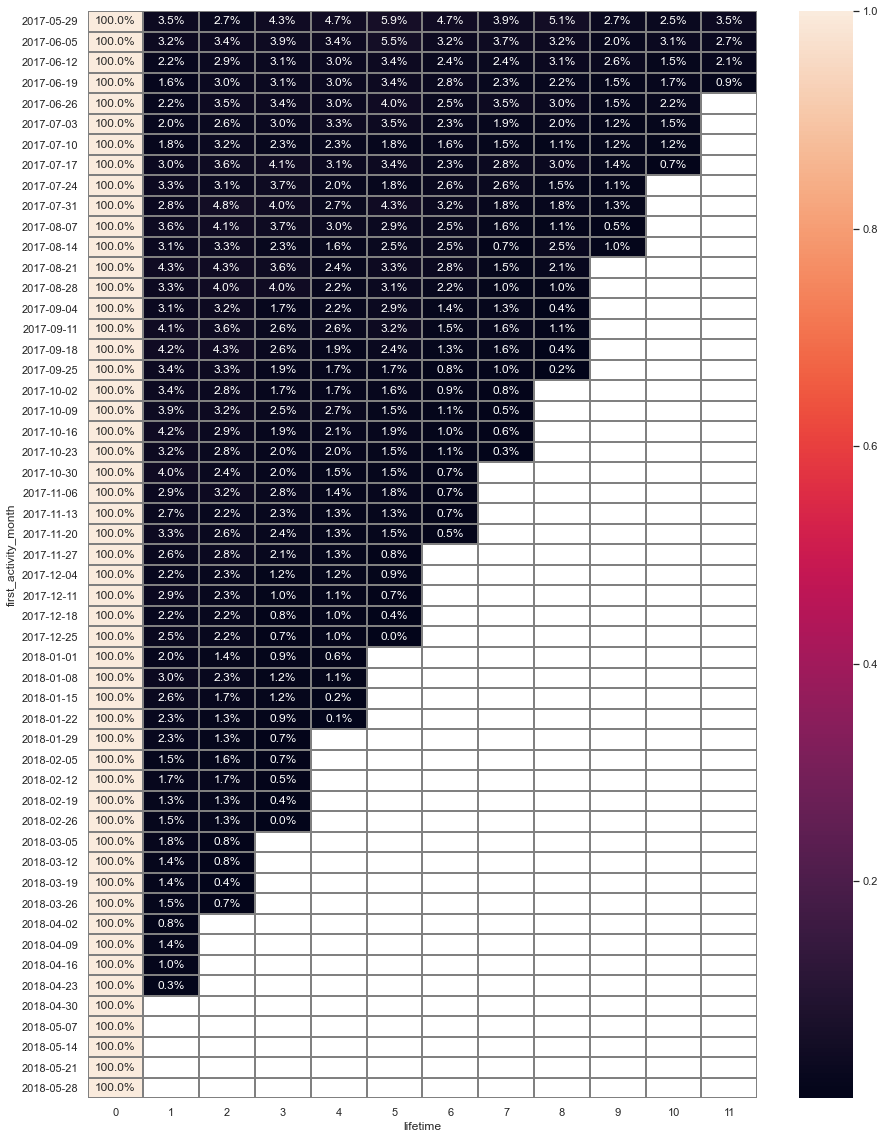

Ресурс номер 2


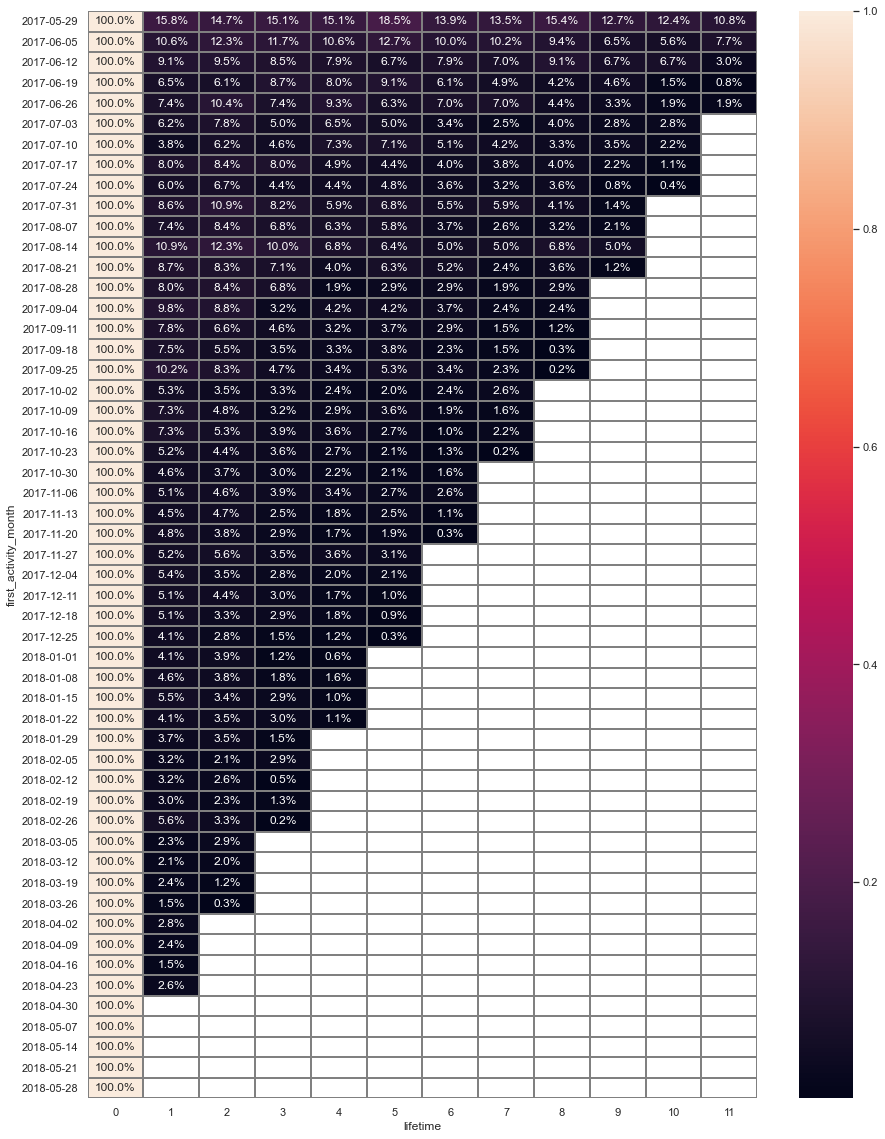

Ресурс номер 5


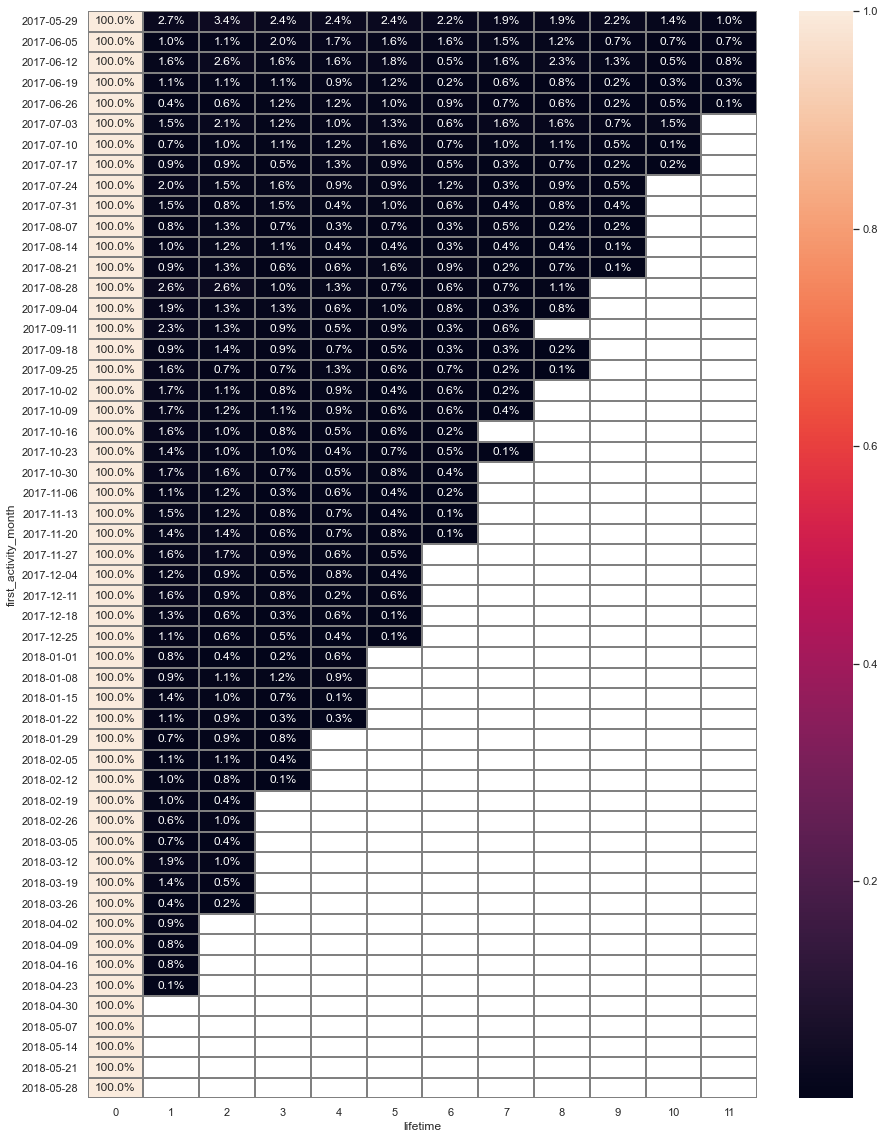

Ресурс номер 9


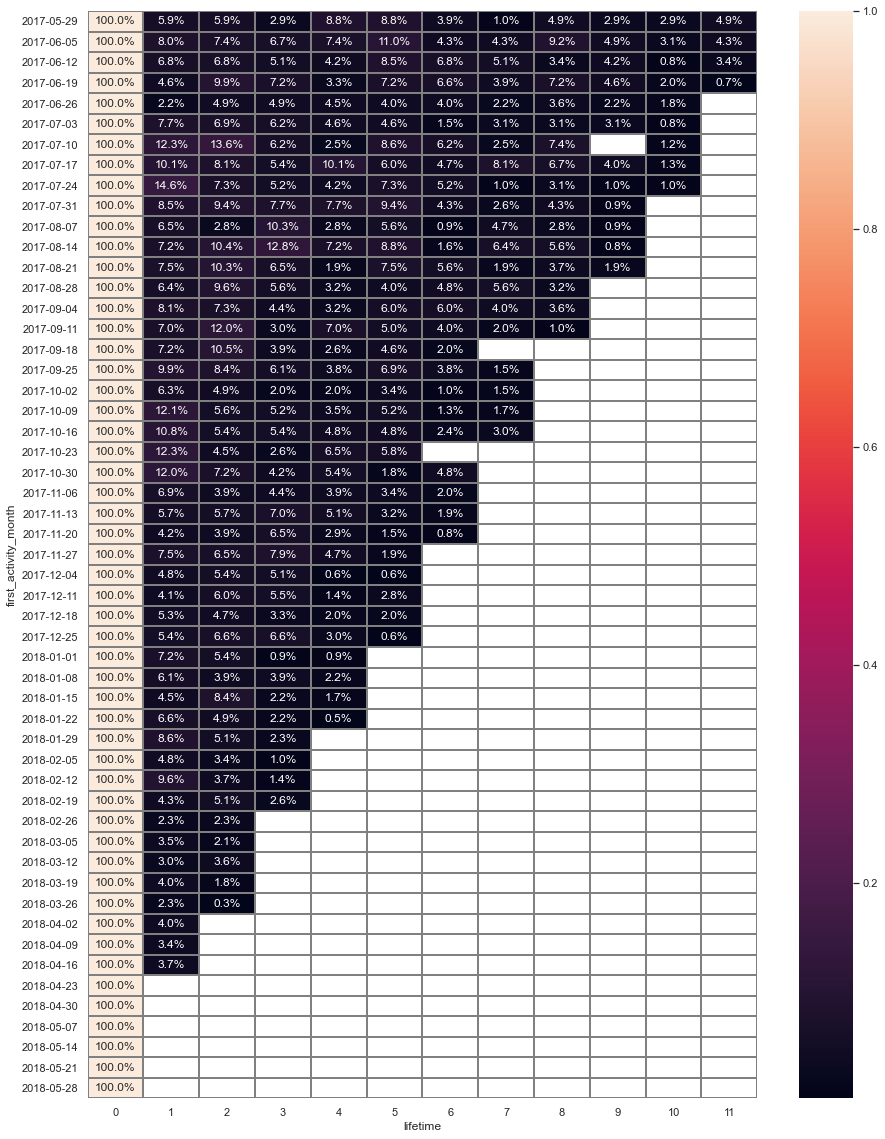

Ресурс номер 3


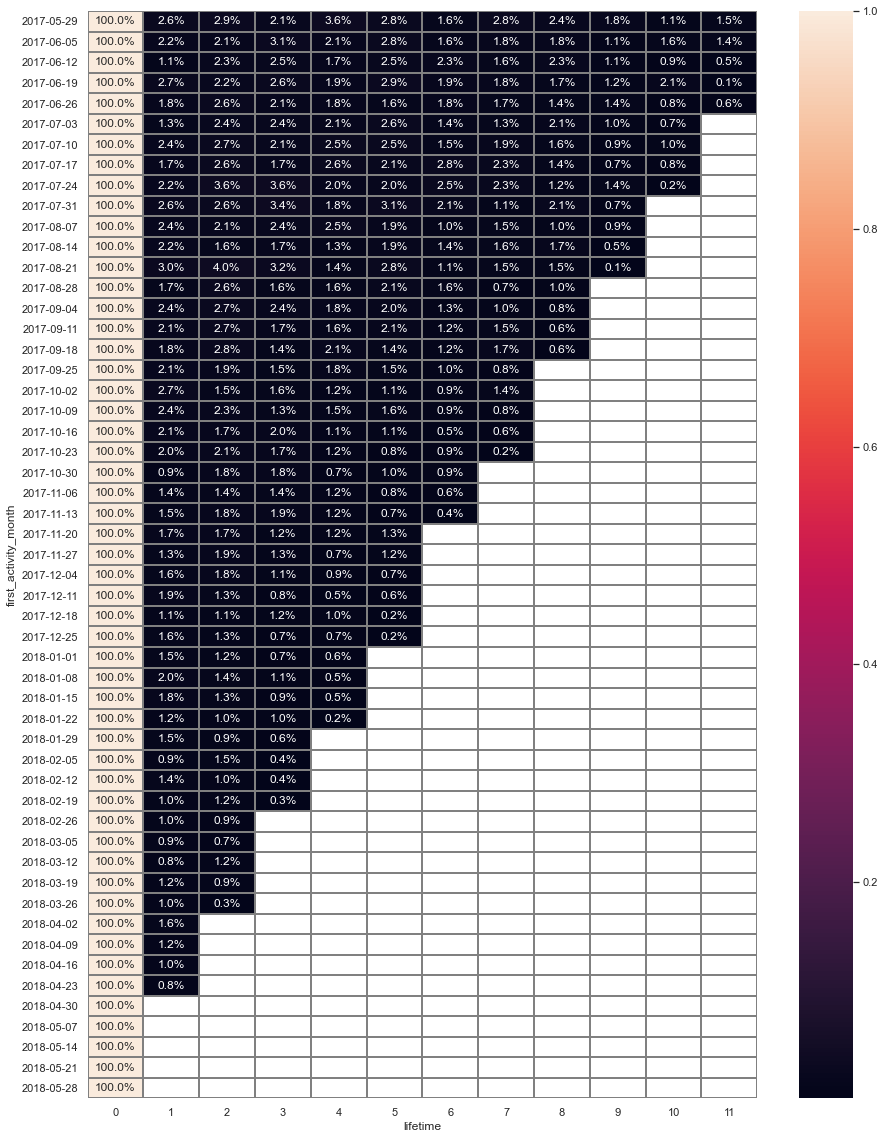

Ресурс номер 1


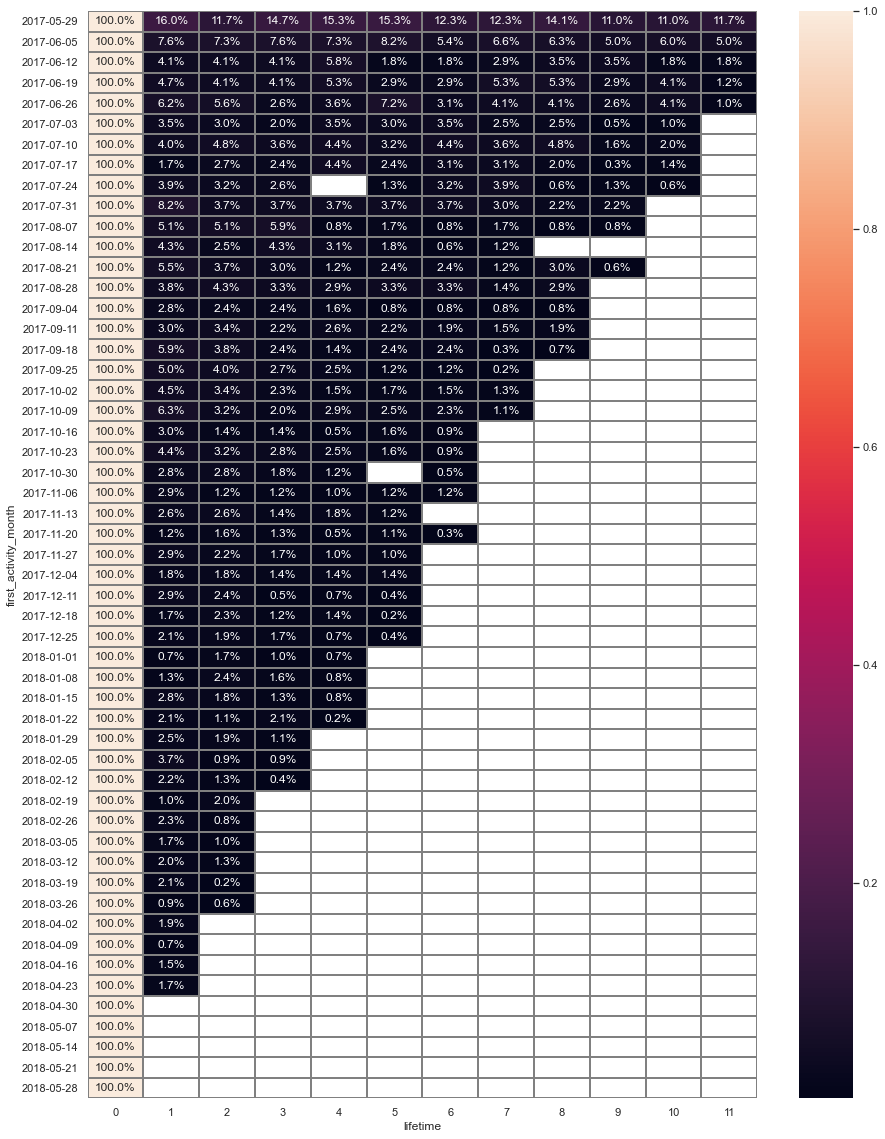

Ресурс номер 10


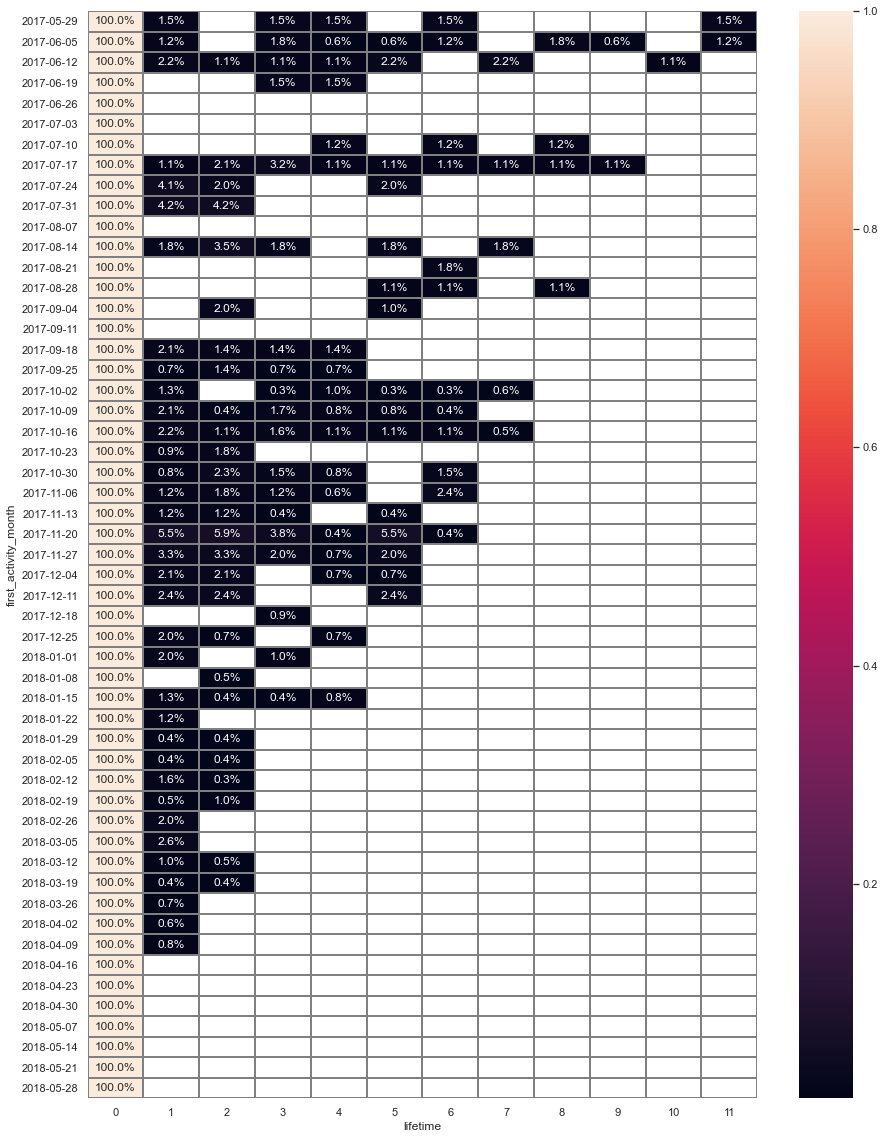

Ресурс номер 7


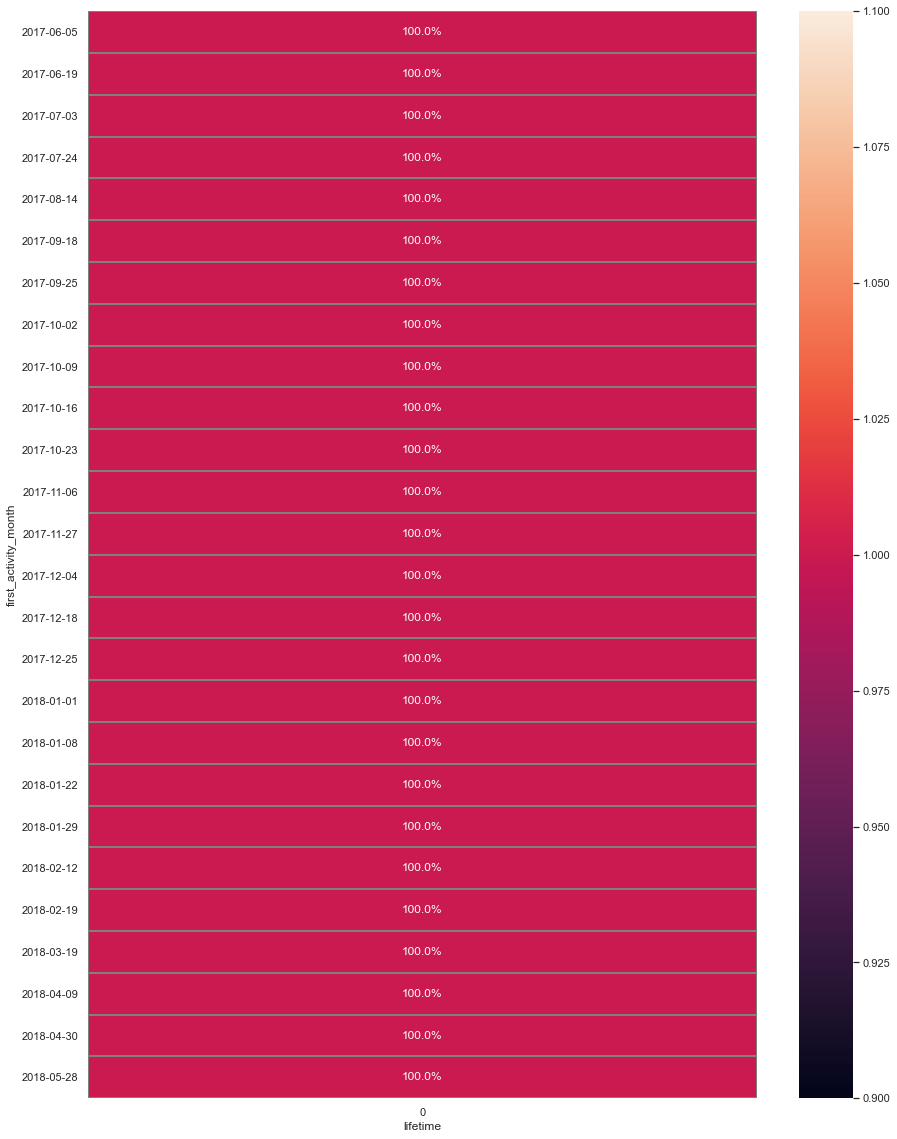

Ресурс номер 6


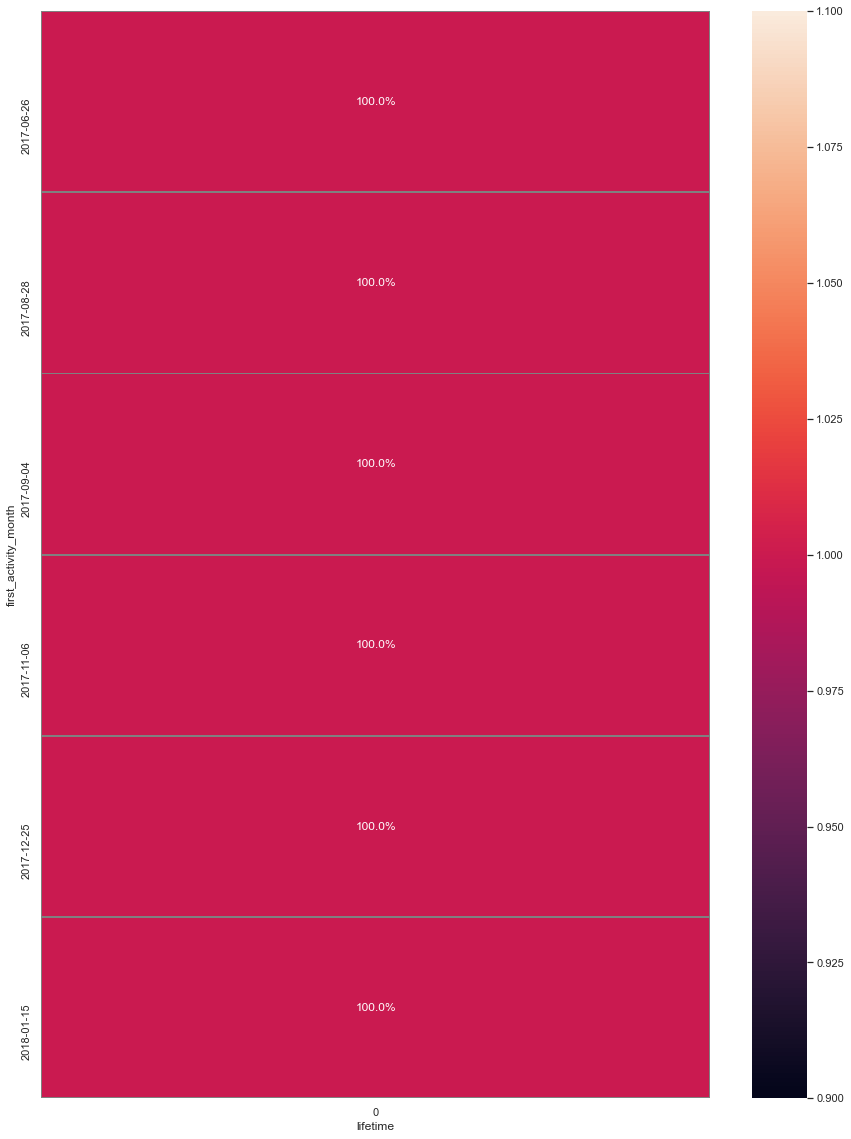

In [136]:
for source in visits['source_id'].unique():
    print('Ресурс номер {}'.format(source))
    first_source_visits = visits[visits['source_id'] == source]
        
    sns.set(style='white')
    plt.figure(figsize=(15,20))
    sns.heatmap(retention_rate(first_activity(first_source_visits)), annot=True, fmt='.1%',\
            linewidth=1, linecolor='grey')
    plt.show()

Если рассматривать таблицу в разрезе ресурсов, то наилучшие показатели за все время наблюдались у 2 ресурса, то есть через него люди возвращаются чаще всего. У ресурса 9 есть некоторые когорты, в первые 3 месяца у которых сохраняется высокий показатель Retntion Rate. У первого ресурса у первой когорты одни из высоких показаетелей.

Пользователи, пришедшие из ресурсов 6 и 7 больше не возвращались на сайт. Значит, что эти ресурсы довольно неэффективны.

Пользователи начинают покупать через 60 секунд. Ровно столько, в среднем, длиться сессия на сайте.

**Количество покупок за период**

Выяснила, что в среднем пользователь делает 1 покупку в месяц на сайте Яндекс Афиши.

И с компьютера, и с телефона, в среднем пользователь совершает одну покупку.

Люди, пришедшие из 6 ресурса, ничего не купили, а из 7 - всего одна покупка, поэтому можно порекомендовать отделу маркетинга не вкладываться больше в этот ресурс.

Выяснила, что у первого ресурса кол-во покупок на одного пользователя в конце 2017 года и в 2018 году больше 1.5, значит, что пользователь возвращается за покупкой на сайт еще раз.

**Средний чек**

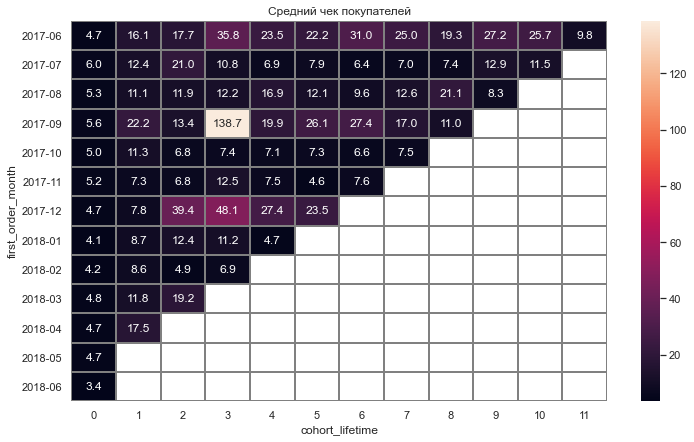

In [137]:
plt.figure(figsize=(12,7))
plt.title('Средний чек покупателей')
sns.heatmap(avr_money(month(merge_table(first_activity_date(visits)))),\
            annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

Видно, в первой когорте средний чек вырос к 4 месяцу жизни, к 7 месяцу жизни. В первой когорте средний чек покупателя держался на протяжении всего времени довольно хорошо. В когорте 2017 - 09 средний чек очень вырос к 4 месяцу жизни, это как раз период предновогожней закупки подарков.
Несмотря на то, что в некоторых когортах в определенный месяц ее жизни средний чек достигает довольно высокое значение, к примеру в когорте 2017-09 к 4 месяцу (138.7), средний чек по всей выборке остается довольно низким(4,99).

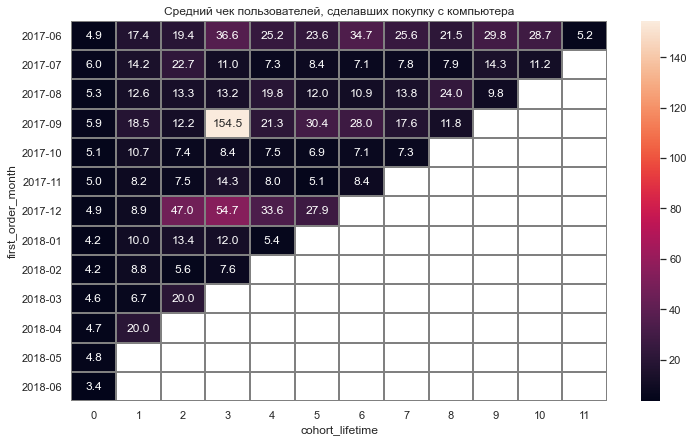

In [138]:
plt.figure(figsize=(12,7))
plt.title('Средний чек пользователей, сделавших покупку с компьютера')
sns.heatmap(avr_money(month(merge_table(first_activity_date(desktop)))),\
            annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

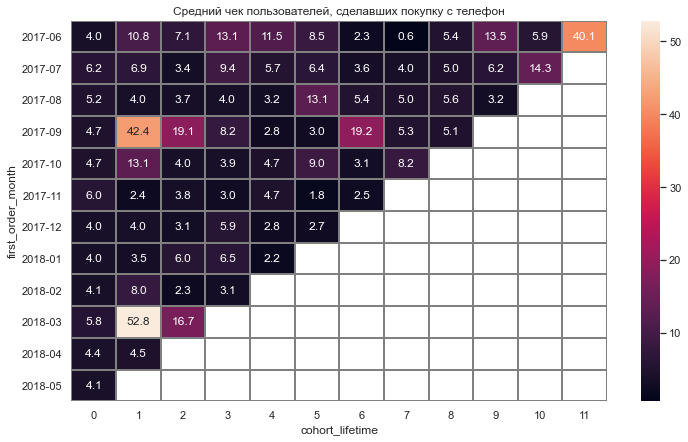

In [139]:
plt.figure(figsize=(12,7))
plt.title('Средний чек пользователей, сделавших покупку с телефон')
sns.heatmap(avr_money(month(merge_table(first_activity_date(touch)))),\
            annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

Средний чек покупок, сделанных с компьютера выше, это может доказывать предположение о том, что версия сайта для телефона или планшета не совсем удобная, для совершения покупки. Но в некоторые месяца средний чек пользователей по когорте выше, чем у пользователь, которые делали покупку с компьютера. Например, в первой когорте 2017-06 к 11 месяцу жизни средний чек среди тех, кто покупал с мобильного устройства выше, чем с компьютера *(40.1 > 5.2)*. Аналогичная ситуация в 2017-09, 2 месяц жизни *(42.4 > 18.5)*, 2018-03, 2 месяц жизни *(52.8 > 6.7)*

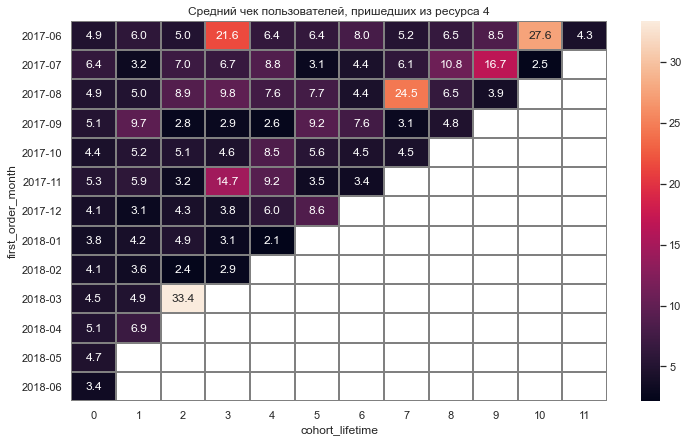

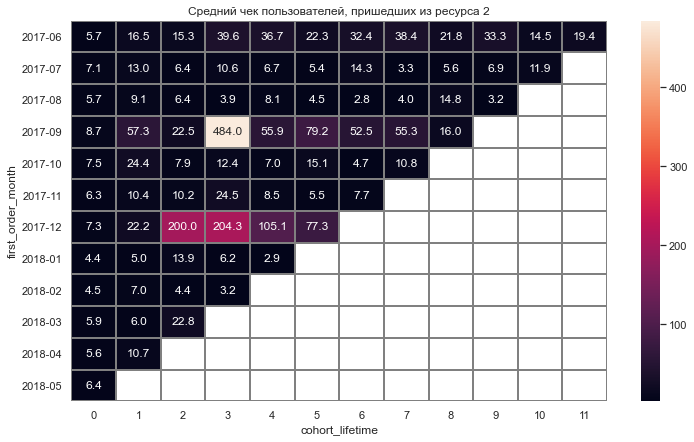

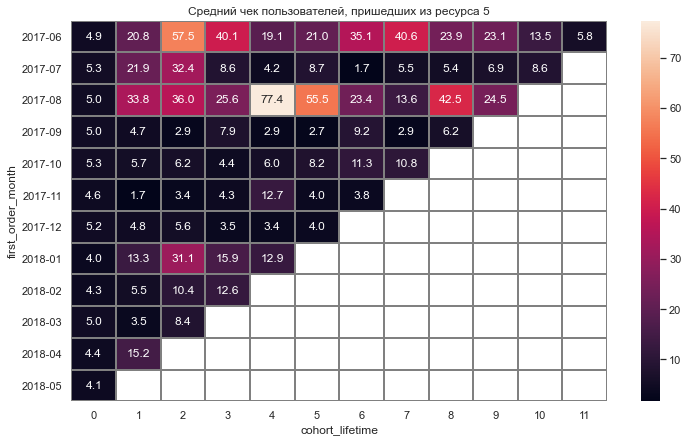

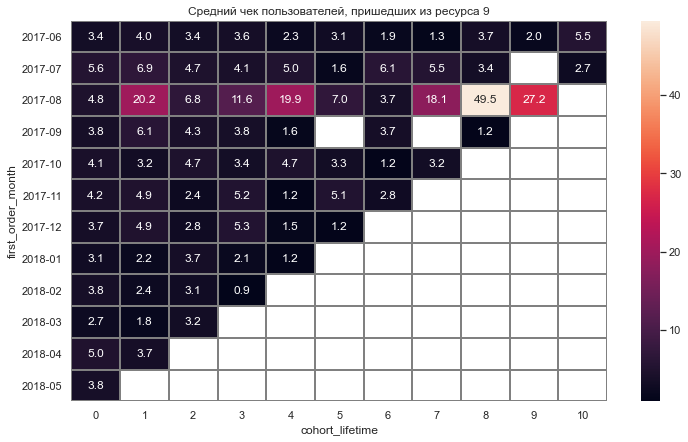

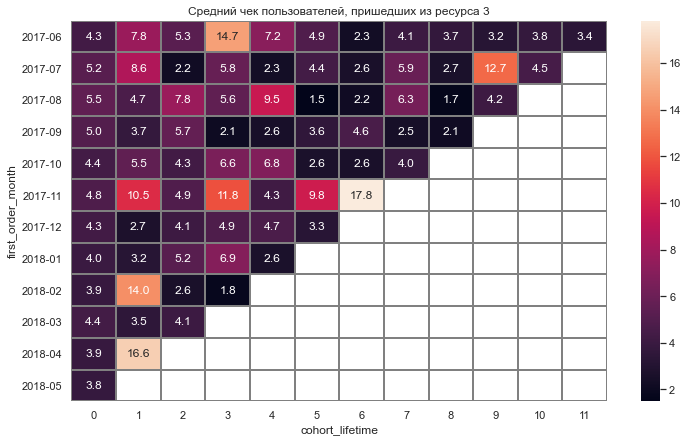

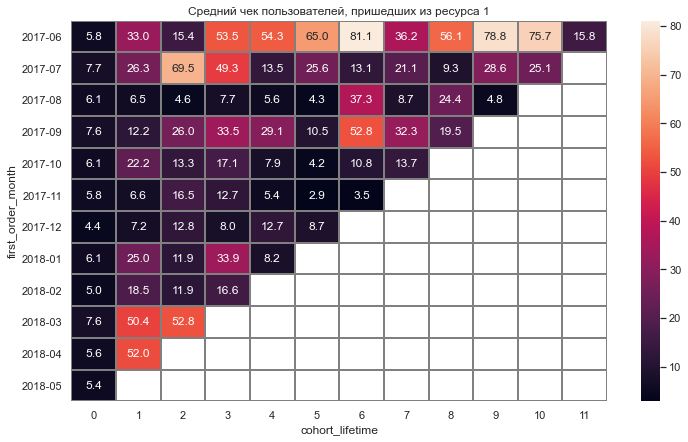

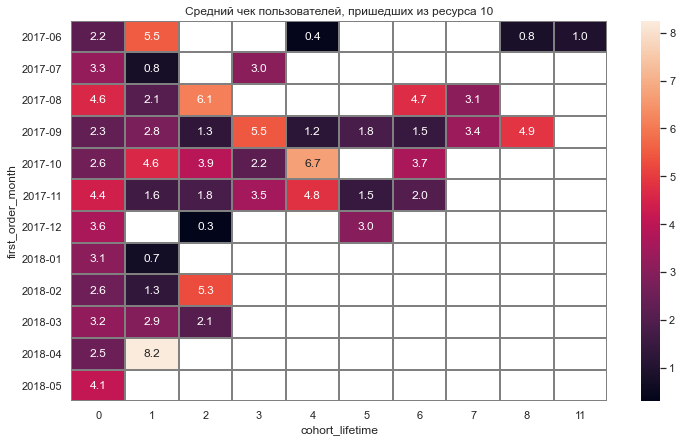

In [140]:
for source in visits_m['first_source_id'].unique():
    first_source_visits = visits[visits['first_source_id'] == source]
    
    plt.figure(figsize=(12,7))
    plt.title('Средний чек пользователей, пришедших из ресурса {}'.format(source))
    sns.heatmap(avr_money(month(merge_table(first_activity_date(first_source_visits)))),\
            annot=True, fmt='.1f', linewidths=1, linecolor='gray')
    plt.show()

Самые высокие показатели сренего чека у второго ресурса(2017-09 к 4 месяцу - 484),(2017-12 с 3 по 5 месяц сохраняется высокое знаение среднего чека в диапазоне 15-200). Средний чек у пользователей, пришедших на сайт с ресурсов 1, 5 имеет неплохой показатель ( в пределах 80) среди когорт. У первого ресурса первой и второй когорты сохраняется довольно высокое значение в течении времени жизни когорты, по сравнению с остальными.

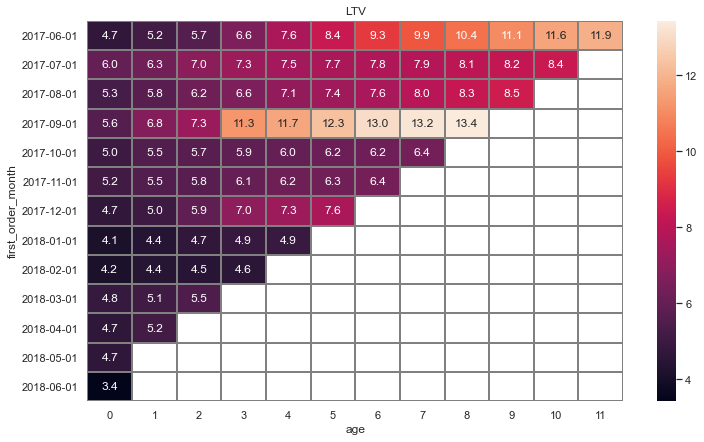

In [141]:
output = output_ltv_one.pivot_table(index='first_order_month',
                                    columns='age',
                                    values = 'ltv',
                                    aggfunc='mean').cumsum(axis=1).round(2)

plt.figure(figsize=(12,7))
plt.title('LTV')
sns.heatmap(output,annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.show()

У когорты 2017-09-01 размер прибыли, которую приносит один клиент в среднем выше, чем у остальных. У когорты 2017-06-01 показатели тоже довольно высокие.

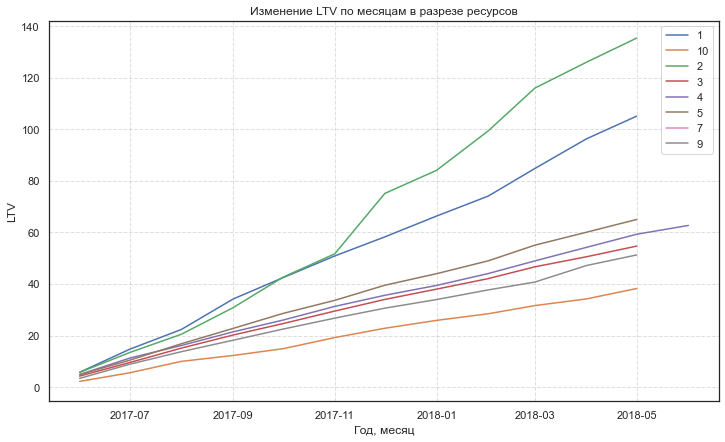

In [142]:
plt.figure(figsize=(12,7))
for source in range(0, len(source_ltv.index)):
    date_inter = source_ltv.loc[source_ltv.index[source]].reset_index()
    plt.plot(date_inter['order_month'], date_inter[date_inter.columns[1]], label=source_ltv.index[source])
    plt.grid(True, linestyle='--', color='grey', which='major', alpha=.25)
    plt.legend()
plt.title('Изменение LTV по месяцам в разрезе ресурсов')
plt.xlabel('Год, месяц')
plt.ylabel('LTV')
plt.show()

Наиболее прибыльный является 2 ресурс. Показатель LTV в каждый месяц чаще находится выше, чем у остальных ресурсов. Первый ресурс до 2017-09 имел схожие показатели LTV, что и 2, но потом он не особо изменял свой показаетль, в то время как у 2 ресурса был скачек в 12 месяце 2017 года. Пожизненная стоимость покупателя у остальных ресурсов сохраняет довольно стабильное положение. Самый низкий показатель LTV имеет 10 ресурс.

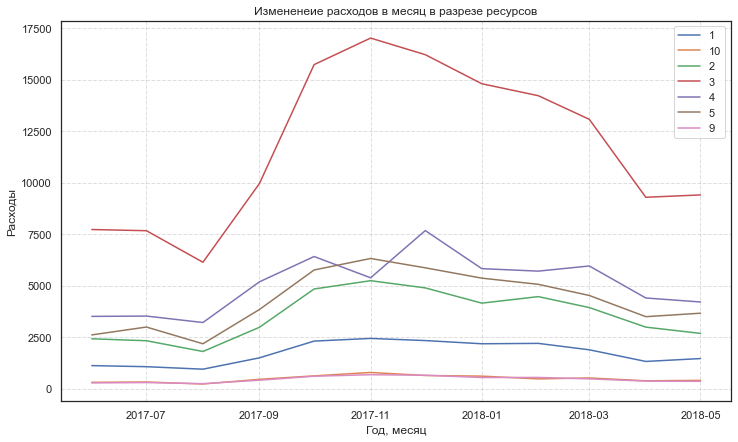

In [143]:
plt.figure(figsize=(12,7))
for source in range(0, len(costs_per_source.index)):
    date_inter = costs_per_source.loc[costs_per_source.index[source]].reset_index()
    plt.plot(date_inter['month'], date_inter[date_inter.columns[1]], label=costs_per_source.index[source])
    plt.legend()
plt.title('Измененеие расходов в месяц в разрезе ресурсов')
plt.xlabel('Год, месяц')
plt.ylabel('Расходы')
plt.grid(True, linestyle='--', color='grey', which='major', alpha=.25)

**ROMI и CAC**

<AxesSubplot:xlabel='age', ylabel='first_order_month'>

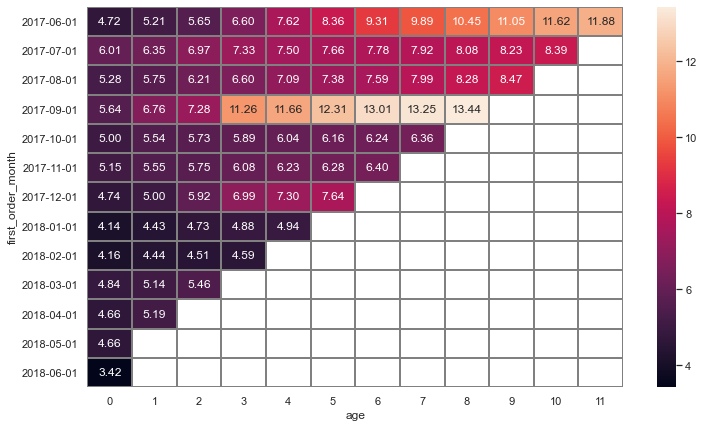

In [145]:
plt.figure(figsize=(12,7))
sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray')

Окупились:
* Июньская когорта на 8 месяц (ROMI=1.11)
* Сентябрьская когорта на 4 месяц (ROMI=1.19)




Остальные не окупились, но многие когорты были близки к этому, например июльская когорта ( через месяца 2), августовская, январьская.

Среднее количество месяцев до окупаемости когорты 5.5

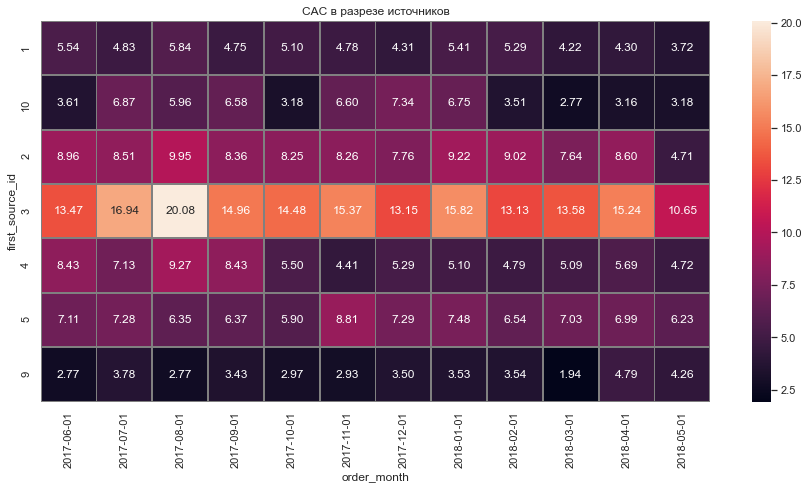

In [146]:
plt.figure(figsize=(15,7))
sns.heatmap(output_cac_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title('CAC в разрезе источников')
plt.show()

<AxesSubplot:xlabel='order_month'>

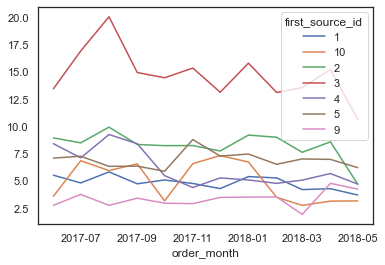

In [147]:
output_cac_source.T.plot()

Больше всего вложили денег на привлечение клиентов в 4 ресурсе, причем 2018-06 вложились больше, чем в остальные месяцы, что довольно подозрительно. Стоит узнать, является ли данный показатель САС на этот месяц реальным, или это ошибка. На 2018-05 3 ресурс имел наиболее высокий показатель CAC.

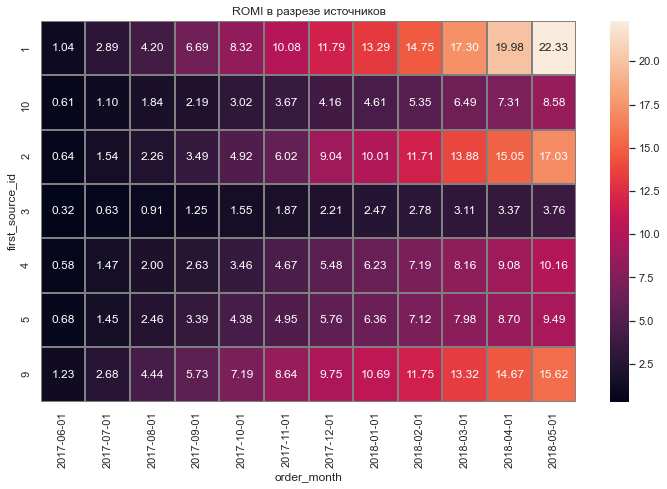

In [148]:
plt.figure(figsize=(12,7))
sns.heatmap(output_romi_source, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title('ROMI в разрезе источников')
plt.show()

Вложения в 1 источник окупились через 6 месяцев, во 2 источник - через 8 месяцев, в 9 - через 9 месяцев. Такие источники, как 4,5,10 близки к окупаемости. Источник 3 имеет очень низкий Romi даже под через 11 месяцев. На 2018-05 видно, что больше всего вложились в 3 ресурс, но он имеет наименьший показатель окупаемости.

Из анализа таблиц, можно посоветовать отделу маркетинга следующие пункты:
* Пользователи, пришедшие из ресурсов 6 и 7 больше не возвращались на сайт, также пользователи, пришедшие из 6 ресурса, ничего не купили, из 7 ресурса совершена всего одна покупка. Вложения в данные ресурсы не эффективны, считаю, что отделу маркетинга стоит пересмотреть их, может сократить или совсем перестать вкладываться.
* Средний чек пользователей, пришедших из 1,2 и 5 ресурса имеет довольно высокий показатель. Вложения в 1 и 2 источник окупились, а значит работа с этими ресурсами ведется правильно. Можно попробовать увеличеить вложения, что может поспособствовать увеличению пользователей. Пятый ресурс близок к окупаемости, я бы понаблюдала бы за поведением пользователей из этого ресурса до момента окупаемости.
* 2 ресурс имеет высокий показатель LTV за все время жизни, этот ресурс окупился через 8 месяцев.
* Больше всего расходов ушло на 3 ресурс, его показатели окупаемости очень низкие, надо уменьшать расходы на данный ресурс